## let's check three things in the fMRI data
1. tSNR (of preprocessed data)
2. left > right button presses t-test
3. Physiological noise regression F-tests

In [16]:
import glob
import os
import re
import shutil
import random
import string

import mkl
mkl.set_num_threads(4)   # by default, use 4 threads for NP
import numpy as np
import pandas as pd

import nilearn
from nilearn import plotting, image
from nilearn.input_data import NiftiMasker
import nibabel as nib
from nipype.interfaces import ants
import nighres

# simple modeling
from nilearn.glm.first_level import FirstLevelModel #nilearn must be -v >= 0.7.0

import subprocess
import json
import multiprocessing as mp
from functools import partial
import joblib
from joblib import Parallel, delayed

from utils import apply_warp

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def find_rois(sub, atlas_name='ATAG', space='T1w'):
    if atlas_name == 'ATAG':
        if space == 'MNI152NLin2009cAsym' or space == 'mni':
            ### Rois in MNI09c-space
            mask_dir='/home/Public/trondheim/sourcedata/masks/MNI152NLin2009cAsym_res-1p5'
            fns = sorted(glob.glob(mask_dir + '/space-*'))
            names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_res-1p5_label-(?P<label>[a-zA-Z0-9]+)_probseg_def-img.nii.gz', fn).groupdict()['label'] for fn in fns]
        else:
            mask_dir = f'../derivatives/masks_atag_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
            fns = sorted(glob.glob(mask_dir))
            names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>[a-zA-Z0-9]+).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'MASSP':
        mask_dir = f'../derivatives/masks_massp_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'thalamus':
        mask_dir = f'../derivatives/masks_thal_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>.*).nii.gz', fn).groupdict()['label'] for fn in fns]

    roi_dict = dict(zip(names, fns))
    return roi_dict

def load_atlas(sub, atlas_name='MASSP', space='T1w'):
    from nilearn import image
    
    roi_dict = find_rois(sub, atlas_name, space)
    combined = image.concat_imgs(roi_dict.values())
    
    class AttrDict(dict):
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self
            
    roi_atlas = AttrDict({'maps': combined,
                          'labels': roi_dict.keys()})
    
    return roi_atlas

In [18]:
# sub = '011'
# boldref = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[0]
# nilearn.plotting.plot_prob_atlas(load_atlas(sub).maps, bg_img=boldref)

# 1. tSNR

In [19]:
# function for tSNR
def high_pass(nii, verbose=False, mask=None):
#     print('Highpass-filtering')
    t_r = nii.header['pixdim'][4]
    if mask is not None:
        hp_masker = NiftiMasker(mask, high_pass=1./128, t_r=t_r)
    else:
        hp_masker = NiftiMasker(high_pass=1./128, t_r=t_r)
    
    # Generate & fit NiftiMasker
    hp_data = hp_masker.fit_transform(nii)
    
    # back to brain space
    inver = hp_masker.inverse_transform(hp_data)

    # add mean of timeseries per voxel back
    highpassed_data = inver.get_fdata() + np.mean(nii.get_fdata(), 3)[:,:,:,np.newaxis]
    highpassed_img = nib.Nifti1Image(highpassed_data, inver.affine, header=nii.header)
    
    return highpassed_img

def make_tsnr_image(nii, exclude_volumes=4):
    ''' exclude_volumes: how many (non-steady state) volumes at the beginning of the run should be excluded?'''
#     print('Calculating tSNR')
    mean_ = nilearn.image.math_img('nii[:,:,:,{}:].mean(-1)'.format(exclude_volumes), nii=nii)
    std_ = nilearn.image.math_img('nii[:,:,:,{}:].std(-1)'.format(exclude_volumes), nii=nii)
    tsnr = nilearn.image.math_img('nii[:,:,:,{}:].mean(-1)/nii[:,:,:,{}:].std(-1)'.format(exclude_volumes,exclude_volumes), nii=nii)
    
    return tsnr, mean_, std_

## extracting value from mask
def get_roi_weighted_average(nii, atlas):
    data = nii.get_fdata()
    
    # identify voxels that shouldn't be weighted: cnr/tsnr can't be <0, >1000, or nan.
    # these can arise, mostly at the edges of the brain, due to numerical issues (T2* estimation, division by small noise, etc)
    bad_voxel_idx = (data < 0) | (data > 100000) | np.isnan(data)
    
    # set to 0 in data
    data[bad_voxel_idx] = 0
    
    out = pd.Series(index=pd.Index(atlas.labels))
    for mask_id in np.arange(atlas.maps.shape[-1]):
        # get in mask
        mask_label = [x for x in atlas.labels][mask_id]

        this_mask = image.index_img(atlas.maps, mask_id).get_fdata()
        this_mask[bad_voxel_idx] = 0  # bad values, don't weigh these
        this_mask[this_mask<0.01] = 0  # prevent negative weights
        
        if this_mask.sum() > 0:
            val_weighted = np.average(data, weights=this_mask)  # inf * 0 = np.nan -> manually set np.nans to 0
        else:
            val_weighted = 0
        out[mask_label] = val_weighted
    return out

In [20]:
def get_tsnr(fn, overwrite_hp=False, overwrite_tsnr=False):
    regex = re.compile('.*sub-(?P<sub>\d+)_ses-(?P<ses>\S+)_task-(?P<task>\S+)_run-(?P<run>\d)_space-T1w_desc-preproc_bold.*')
    gd = regex.match(fn).groupdict()
#     print(fn)
#     print(gd)
    brain_mask = nib.load(fn.replace('preproc_bold', 'brain_mask'))

    # has this file been highpassed?
    hp_save_fn = fn.replace('fmriprep/fmriprep', 'high_passed_func')
    if os.path.exists(hp_save_fn) and not overwrite_hp:
        hp_data = nib.load(hp_save_fn)
    else:
        nii = nib.load(fn)
        print('Highpass-filtering {}'.format(fn.split('/')[-1]))
        hp_data = high_pass(nii, mask=brain_mask)
        os.makedirs(os.path.dirname(hp_save_fn), exist_ok=True)
        hp_data.to_filename('../derivatives/high_passed_func/sub-{}/ses-{}/func/{}'.format(gd['sub'], gd['ses'], os.path.basename(fn)))

    # Has tsnr nii already been created?
    tsnr_save_fn = fn.replace('fmriprep/fmriprep', 'tsnr').replace('desc-preproc_bold', 'desc-tsnr')
    if os.path.exists(tsnr_save_fn) and not overwrite_tsnr:
        tsnr = nib.load(tsnr_save_fn)
    else:
        print('Calculating tSNR of {}'.format(tsnr_save_fn.split('/')[-1]))
        tsnr, mean_, std_ = make_tsnr_image(hp_data)
        os.makedirs(os.path.dirname(tsnr_save_fn), exist_ok=True)
        
        tsnr.to_filename(tsnr_save_fn)
        mean_.to_filename(tsnr_save_fn.replace('-tsnr', '-mean'))
        std_.to_filename(tsnr_save_fn.replace('-tsnr', '-std'))
    
    # extract values and save to csv
    for atlas_name in ['MASSP', 'ATAG', 'thalamus']:
        fn_out = f'../derivatives/tsnr/sub-{{sub}}/ses-{{ses}}/func/sub-{{sub}}_ses-{{ses}}_task-{{task}}_run-{{run}}_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'.format(**gd)
        
        if os.path.exists(fn_out) and not overwrite_tsnr:
            continue
        
        try:
            atlas = load_atlas(sub=gd['sub'], atlas_name=atlas_name, space='T1w')
        except:
            # not all subs have MASSP labels yet
            
            continue
        print(gd)
#         if not (tsnr.affine == atlas.maps.affine).all():
#             print('Atlas and tSNR map do not have the same affine, rerun highpassing & tsnr creation! {}'.format(fn))
#             return atlas, tsnr
#             break
#         print(atlas_name)
        tsnr_table = pd.DataFrame(get_roi_weighted_average(tsnr, atlas=atlas)).T
        tsnr_table['subject'] = gd['sub']
        tsnr_table['session'] = gd['ses']
        tsnr_table['task'] = gd['task']
        tsnr_table['run'] = gd['run']
        tsnr_table.set_index(['subject', 'session', 'task', 'run'])
        
        tsnr_table.to_csv(fn_out, sep='\t', index=False)
    
    # warp to MNI
    fn_mni_space = tsnr_save_fn.replace('T1w', 'MNI152NLin2009cAsym')
    if (not os.path.exists(fn_mni_space)) or overwrite_tsnr:
        tsnr_warped = apply_warp(tsnr_save_fn, sub=gd['sub'])
        os.rename(tsnr_warped, fn_mni_space)
        
        mean_warped = apply_warp(tsnr_save_fn.replace('-tsnr', '-mean'), sub=gd['sub'])
        os.rename(mean_warped, fn_mni_space.replace('-tsnr', '-mean'))
        
        std_warped = apply_warp(tsnr_save_fn.replace('-tsnr', '-std'), sub=gd['sub'])
        os.rename(std_warped, fn_mni_space.replace('-tsnr', '-std'))
    
    return 0

In [21]:
all_funcs = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses*/func/*T1w*_bold.nii.gz'))
# subs = ['002','003','004','005','006','007','008','009','010','011']

# subs = ['012','013','014','015','016','017','018','019','020','021']
# subs = ['022','023','024','025','026']
# subs = all_subjects = ['027','029','030','031','032']
subs=['026']

all_funcs = [x for x in all_funcs if x.split('/')[4].split('-')[1] in subs]
all_funcs = [x for x in all_funcs if 'sstmsit' in x]
all_funcs

['../derivatives/fmriprep/fmriprep/sub-026/ses-sstmsit/func/sub-026_ses-sstmsit_task-msit_run-1_space-T1w_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/fmriprep/sub-026/ses-sstmsit/func/sub-026_ses-sstmsit_task-msit_run-2_space-T1w_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/fmriprep/sub-026/ses-sstmsit/func/sub-026_ses-sstmsit_task-sst_run-1_space-T1w_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/fmriprep/sub-026/ses-sstmsit/func/sub-026_ses-sstmsit_task-sst_run-2_space-T1w_desc-preproc_bold.nii.gz']

In [22]:
# all_funcs = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses*/func/*T1w*_bold.nii.gz'))
# all_funcs = [x for x in all_funcs if not 'sub-001' in x]
# all_funcs = all_funcs[:250]

# all_funcs = [x for x in all_funcs if 'anatomical' in x]
# n_jobs = number of cores - BE CAREFUL OF MEMORY LOAD! Each process takes ~5% of available RAM
# Parallel(n_jobs=12, verbose=1)(delayed(get_tsnr)(x) for x in all_funcs)

def get_tsnr_catch(func):
    try:
        get_tsnr(func, overwrite_hp=True, overwrite_tsnr=False)
        return 0
    except:
        return '{} FAILED'.format(func)

# old stuff
with mp.Pool(10) as p:   #- BE CAREFUL OF MEMORY LOAD! Each process takes ~5% of available RAM # sometimes hangs??(sct) 
    p.map(get_tsnr_catch, all_funcs)

Highpass-filtering sub-026_ses-sstmsit_task-sst_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-026_ses-sstmsit_task-msit_run-2_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-026_ses-sstmsit_task-msit_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-026_ses-sstmsit_task-sst_run-2_space-T1w_desc-preproc_bold.nii.gz





In [ ]:
# for func in all_funcs:
#     print(func)
#     get_tsnr(func)

3V         4V      Amg-l      Amg-r  \
subject session    task  run                                               
2       anatomical rs    1    32.949165  50.203609  42.645822  42.724151   
                         2    31.355558  48.225363  36.022104  39.277224   
3       anatomical rs    1    30.387970  44.219674  44.484534  39.022927   
                         2    27.993406  40.710275  40.821399  36.060088   
4       anatomical rs    1    25.205105  31.749501  37.514331  29.700904   
...                                 ...        ...        ...        ...   
38      rlsat      rlsat 3    24.339603  35.591795  37.967997  40.078867   
        sstmsit    msit  1    24.225623  40.078706  42.094313  39.377537   
                         2    24.430867  36.643533  40.137387  38.786719   
                   sst   1    22.848508  32.904998  37.603962  37.559159   
                         2    23.184116  33.300727  37.629674  36.402891   

                                   Cl-l       Cl-r      GPe-l      GPe-r  \
subject session    task  run                                               
2       anatomical rs    1    69.140951  70.458350  38.832091  39.934816   
                         2    66.336647  67.773602  35.870294  38.517891   
3       anatomical rs    1    63.347121  50.314141  37.905313  35.098814   
                         2    63.759103  51.462428  35.157858  35.180294   
4       anatomical rs    1    53.756810  47.936310  32.650361  32.298784   
...                                 ...        ...        ...        ...   
38      rlsat      rlsat 3    61.864241  51.531410  37.435680  37.065945   
        sstmsit    msit  1    61.481391  52.912125  35.335794  35.260063   
                         2    60.567437  52.671632  34.614284  35.138770   
                   sst   1    59.107757  49.696116  34.060437  34.884451   
                         2    59.213781  47.851425  34.124647  34.891061   

                                  GPi-l      GPi-r  ...      STN-r      Str-l  \
subject session    task  run                        ...                         
2       anatomical rs    1    40.179173  31.208735  ...  30.290243  57.775266   
                         2    35.167047  36.833916  ...  28.783538  52.412478   
3       anatomical rs    1    37.406952  36.906175  ...  32.466689  52.238714   
                         2    35.207645  35.008724  ...  32.123869  50.110218   
4       anatomical rs    1    32.082853  29.079042  ...  33.980804  44.308119   
...                                 ...        ...  ...        ...        ...   
38      rlsat      rlsat 3    30.893503  34.350335  ...  32.258958  48.835650   
        sstmsit    msit  1    33.918058  32.530418  ...  32.028331  51.166170   
                         2    32.028230  30.974278  ...  31.651546  49.795026   
                   sst   1    30.922828  31.189852  ...  29.161009  46.951413   
                         2    31.221061  29.922811  ...  30.030261  47.950681   

                                  Str-r      Tha-l      Tha-r      VTA-l  \
subject session    task  run                                               
2       anatomical rs    1    60.123949  57.826926  59.938998  39.232461   
                         2    54.540980  52.797416  57.675239  34.518427   
3       anatomical rs    1    52.333644  51.008448  50.907751  35.908653   
                         2    50.295956  49.890426  49.320142  34.754361   
4       anatomical rs    1    46.338344  43.964632  45.074791  35.446538   
...                                 ...        ...        ...        ...   
38      rlsat      rlsat 3    51.149136  45.327123  47.560198  37.203827   
        sstmsit    msit  1    52.893459  45.364808  47.252006  38.718768   
                         2    52.574369  45.272722  47.217056  38.148244   
                   sst   1    49.465200  43.222987  45.090288  35.612640   
                         2    49.359460  43.211048  45.778358  35.384165   

                

ACC         M1        THA       lGPe  \
subject session    task  run                                               
2       anatomical rs    1    70.776481  84.114614  58.048688  41.876693   
                         2    64.339292  70.493450  54.644630  37.934528   
3       anatomical rs    1    63.026034  81.096685  49.476940  40.947984   
                         2    58.647042  74.530648  47.915245  37.779212   
4       anatomical rs    1    49.682728  65.847691  43.763856  34.913438   
...                                 ...        ...        ...        ...   
38      rlsat      rlsat 3    63.622140  71.683915  45.029893  37.735925   
        sstmsit    msit  1    65.403433  76.498705  45.300876  36.572573   
                         2    65.389248  73.090763  45.312991  35.353447   
                   sst   1    58.402666  64.141945  43.000131  34.458727   
                         2    59.333205  65.196671  43.491883  34.759490   

                                   lGPi        lLC        lM1    lPreSMA  \
subject session    task  run                                               
2       anatomical rs    1    43.941887  53.289368  85.174265  82.542936   
                         2    38.770424  53.790850  70.846318  74.582620   
3       anatomical rs    1    41.243436  53.336427  79.733658  77.001996   
                         2    41.919194  52.851360  73.854074  74.073463   
4       anatomical rs    1    38.812170  35.603082  66.244339  75.859588   
...                                 ...        ...        ...        ...   
38      rlsat      rlsat 3    40.918191  37.848289  74.365067  84.281212   
        sstmsit    msit  1    42.455217  34.956818  80.611018  84.774147   
                         2    41.357183  34.828541  76.069786  84.528260   
                   sst   1    40.372151  34.586584  68.469870  78.915457   
                         2    41.433527  32.018423  68.810011  78.683589   

                                    lSN       lSTN  ...       rGPe       rGPi  \
subject session    task  run                        ...                         
2       anatomical rs    1    30.777259  40.436625  ...  40.202919  39.902453   
                         2    26.088658  35.055141  ...  41.591887  44.731040   
3       anatomical rs    1    28.863835  40.135543  ...  38.195000  39.315647   
                         2    28.290092  39.598092  ...  37.843881  38.964888   
4       anatomical rs    1    29.664590  31.063242  ...  34.081520  36.309574   
...                                 ...        ...  ...        ...        ...   
38      rlsat      rlsat 3    32.576462  37.252976  ...  38.236563  40.815010   
        sstmsit    msit  1    33.333526  38.487027  ...  36.385763  37.952733   
                         2    32.627227  37.692204  ...  36.193677  36.889584   
                   sst   1    31.258921  37.406191  ...  35.709632  37.019447   
                         2    30.464346  36.619680  ...  35.717506  36.053564   

                                   rIFG        rLC        rM1    rPreSMA  \
subject session    task  run                                               
2       anatomical rs    1    73.062101  46.496300  83.265872  72.796554   
                         2    60.107461  49.593755  70.210816  63.834143   
3       anatomical rs    1    67.549478  45.640214  82.219109  73.058969   
                         2    61.847276  44.028476  75.087793  70.960878   
4       anatomical rs    1    46.581606  39.987800  65.546325  69.774129   
...                                 ...        ...        ...        ...   
38      rlsat      rlsat 3    70.233807  37.474788  69.580909  75.303416   
        sstmsit    msit  1    69.454309  34.545505  73.273143  77.426756   
                         2    68.170086  37.608679  70.754117  76.790946   
                   sst   1    61.388073  36.946687  60.747265  69.116918   
                         2    56.654702  35.294465  62.362488  69.806768   

               

AV-l       AV-r       CL-l       CL-r  \
subject session    task run                                               
2       anatomical rs   1    47.991350  54.113789  50.475915  48.512453   
                        2    48.337791  54.012714  49.619141  45.536067   
3       anatomical rs   1    49.463388  48.265120  36.059365  45.031552   
                        2    45.453735  43.633673  38.574966  37.152792   
4       anatomical rs   1    35.426267  41.726629  43.377813  33.278627   
                        2    33.639668  37.431541  40.231468  33.860524   
5       anatomical rs   1    48.244356  47.332498  39.173218  34.115130   
                        2    45.572688  46.530426  41.638418  31.248084   
6       anatomical rs   1    44.337034  47.558113  48.458822  42.101456   
                        2    44.345892  50.371601  46.430626  49.931209   
7       anatomical rs   1    53.806342  62.280054  52.484378  56.975982   
                        2    50.048016  62.213828  53.559640  55.047729   
8       anatomical rs   1    43.391899  43.336246  40.108398  35.671486   
                        2    40.700375  42.118624  43.048274  33.773290   
9       anatomical rs   1    54.085990  52.388477  48.094454  47.969278   
                        2    50.345612  48.679924  45.098448  44.346807   
10      anatomical rs   1    43.254332  43.378210  39.006075  46.669377   
                        2    44.322754  45.108024  36.925751  44.363640   
11      anatomical rs   1    53.481916  57.282598  53.155981  26.837318   
                        2    50.425765  54.372963  47.081278  19.906322   

                                  CM-l       CM-r      CeM-l      CeM-r  \
subject session    task run                                               
2       anatomical rs   1    61.765862  59.829105  55.434651  58.779196   
                        2    55.517592  62.051002  54.743109  59.050904   
3       anatomical rs   1    46.317913  50.168514  52.387102  54.068740   
                        2    46.102766  53.242379  50.205182  51.552132   
4       anatomical rs   1    48.344132  50.814911  52.045515  52.127976   
                        2    47.934290  48.336866  50.394598  49.372337   
5       anatomical rs   1    41.790095  46.052696  44.061518  46.943367   
                        2    37.577390  44.870515  39.239852  46.964221   
6       anatomical rs   1    48.771254  50.531004  52.118117  54.871344   
                        2    48.595132  52.032949  52.574714  52.913245   
7       anatomical rs   1    62.009157  58.739965  51.825297  56.376950   
                        2    56.894418  55.677694  51.078207  60.672423   
8       anatomical rs   1    50.363732  46.564495  50.276416  48.557340   
                        2    53.145309  49.810102  49.741134  48.359969   
9       anatomical rs   1    45.376407  53.754785  52.142477  56.077414   
                        2    45.930915  58.396124  58.188680  64.689219   
10      anatomical rs   1    52.650915  51.782200  48.355909  46.790266   
                        2    51.439900  51.492206  53.461168  51.926091   
11      anatomical rs   1    55.300505  56.208088  49.769834  55.064694   
                        2    52.187521  53.258889  52.722862  53.678326   

                                  LD-l       LD-r  ...     VAmc-l     VAmc-r  \
subject session    task run                        ...                         
2       anatomical rs   1    56.381359  53.484202  ...  54.289823  59.029606   
                        2    51.504252  46.538086  ...  55.751801  60.462570   
3       anatomical rs   1    39.938967  41.040550  ...  56.279286  55.884302   
                        2    39.000547  43.073373  ...  48.897922  48.050242   
4       anatomical rs   1    38.338216  31.226830  ...  52.805827  53.223374   
                        2    36.151341  31.219516  ...  47.465995  52.186478   
5       anatomical rs   1    47.348949  32.887589  ...  43.922396  48.365040   
            

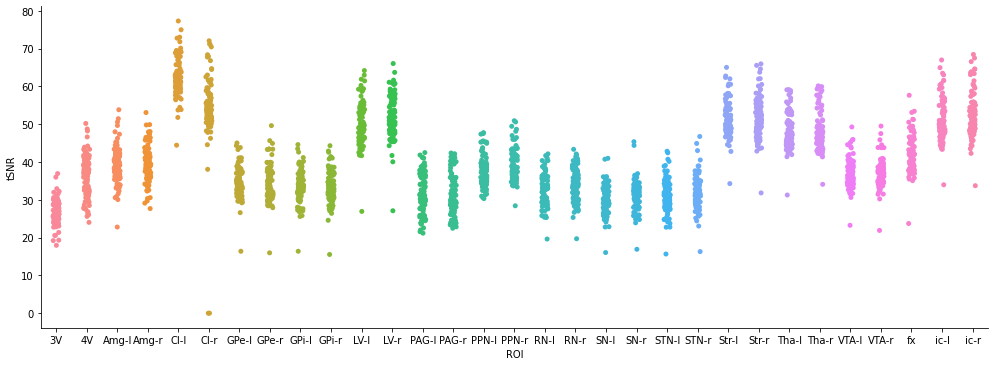

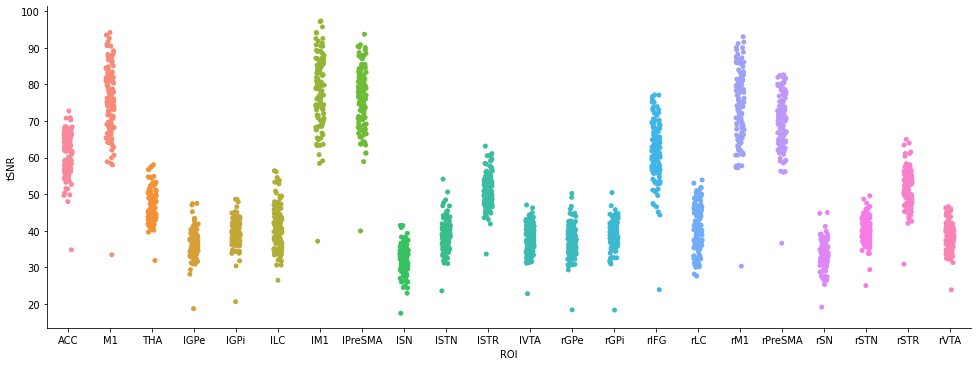

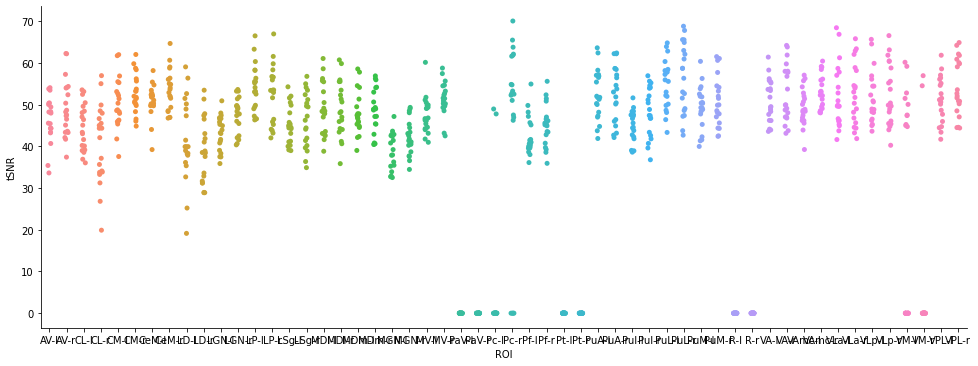

In [46]:
## All tSNR estimates found
for atlas_name in ['MASSP', 'ATAG', 'thalamus']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-*_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    all_tsnr_table.to_csv(f'../derivatives/tsnr/all_tsnrs_{atlas_name}_table.tsv', sep='\t')
#    all_tsnr_table

    fg = sns.catplot(x='ROI', y='tSNR', data=all_tsnr_table.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'))
    plt.gcf().set_size_inches(15,5)
    plt.gcf().savefig(f'../figures/tsnr-{atlas_name}.pdf', bbox_inches='tight')

    display(all_tsnr_table)

# 2. RETROICOR estimation
1. Run PhysIO to get RETROICOR, HRV and RVT

unfortunately we need to call matlab for this...

In [8]:
# def find_physLog_file(subject_n, session_n):

In [4]:
def prep_matlab_args(subject_n, session_n, task, run, overwrite=0):
    info_file = '/home/Public/trondheim/derivatives/phys_log/sub-{subject_n}/ses-{session_n}/func/sub-{subject_n}_ses-{session_n}_task-{task}_run-{run}_Info.log'.format(**locals())
    puls_file = '/home/Public/trondheim/derivatives/phys_log/sub-{subject_n}/ses-{session_n}/func/sub-{subject_n}_ses-{session_n}_task-{task}_run-{run}_PULS.log'.format(**locals())
    resp_file = '/home/Public/trondheim/derivatives/phys_log/sub-{subject_n}/ses-{session_n}/func/sub-{subject_n}_ses-{session_n}_task-{task}_run-{run}_RESP.log'.format(**locals())
    
    if os.path.isfile(info_file) and os.path.isfile(puls_file) and os.path.isfile(resp_file):
        print(f'Log files for {subject_n} {session_n} {task} {run} exist')
    else:
        print(f'Log files for {subject_n} {session_n} {task} {run} do not exist')
        
    nii = nib.load(info_file.replace('Info.log', 'bold.nii.gz').replace('phys_log', 'bids'))
    n_vols = nii.header['dim'][4]
    n_slices = nii.header['dim'][3]
    t_r = nii.header['pixdim'][4]
    per_slice = 0
    save_dir = os.path.dirname(info_file).replace('phys_log', 'retroicor')
    os.makedirs(save_dir, exist_ok=True)
    
    print(f'saving to {save_dir}')
    
    mlcode = '\"cd(\'/home/Public/trondheim/scripts/matlabshit\'); addpath(\'/home/Public/trondheim/scripts/matlabshit/tapas-master/PhysIO/code\'); run_physIO(\'{puls_file}\', \'{resp_file}\', \'{info_file}\', {n_vols}, {n_slices}, {t_r}, \'{save_dir}\', {per_slice}, {overwrite}); exit\"'.format(**locals())
    return mlcode

In [5]:
def find_all_to_run(return_tuples=False):
    # if you want to run everything...
#    all_phys_files = sorted(glob.glob('../derivatives/bids/sub-*/ses-*/func/*_physio.tsv.gz'))
#    all_phys_files = [x for x in all_phys_files if not 'recording-' in x]
#    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-(?P<run>\d).*_physio.tsv.gz')

    all_phys_files = sorted(glob.glob('../derivatives/phys_log/sub-*/ses-*/func/*_Info.log'))
#     all_phys_files = [x for x in all_phys_files if not 'recording-' in x]
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-(?P<run>\d)_Info.log')
    
    all_phys_files_dict = [regex.match(x).groupdict() for x in all_phys_files]
    all_phys_files_df = pd.DataFrame.from_dict(all_phys_files_dict).sort_values(['sub','ses','task', 'run']).drop_duplicates()
    
    dict_list = all_phys_files_df.to_dict(orient='records')
    if return_tuples:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list

def find_which_to_run():
    # finds all runs for which there are RETROICOR regressors, and removes those for which there's an output already
    all_phys_files = find_all_to_run()
    
    to_run = []
    for dict_ in all_phys_files:
        fp = '../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-retroicor_regressors.tsv'.format(**dict_)
        if not os.path.exists(fp):
#             print('{} doesnt exist'.format(fp))
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]

In [7]:
to_run = find_which_to_run()
to_run = [x for x in to_run if os.path.exists('/home/Public/trondheim/derivatives/bids/sub-{}/ses-{}/func/sub-{}_ses-{}_task-{}_run-{}_bold.nii.gz'.format(x[0], x[1], x[0],x[1], x[2], x[3]))]

# to_run = find_all_to_run(True)
# to_run = [x for x in to_run if os.path.exists('/home/Public/trondheim/derivatives/bids/sub-{}/ses-{}/func/sub-{}_ses-{}_task-{}_run-{}_bold.nii.gz'.format(x[0], x[1], x[0],x[1], x[2], x[3]))]
print(to_run)

[('007', 'sstmsit', 'msit', '1'), ('010', 'rlsat', 'rlsat', '2'), ('010', 'rlsat', 'rlsat', '3'), ('018', 'rbrevl', 'rb', '2'), ('018', 'rbrevl', 'revl', '1'), ('018', 'rbrevl', 'revl', '2'), ('018', 'rlsat', 'rlsat', '3'), ('018', 'sstmsit', 'sst', '2'), ('019', 'rbrevl', 'revl', '2'), ('022', 'anatomical', 'rs', '1'), ('022', 'anatomical', 'rs', '2'), ('025', 'sstmsit', 'msit', '2'), ('025', 'sstmsit', 'sst', '2'), ('033', 'mrlc', 'mt', '1'), ('033', 'mrlc', 'mt', '2'), ('033', 'mrlc', 'mt', '3'), ('033', 'mrlc', 'mt', '4'), ('041', 'sstmsit', 'sst', '2'), ('043', 'mrlc', 'mt', '1'), ('043', 'mrlc', 'mt', '2'), ('043', 'mrlc', 'mt', '3'), ('043', 'mrlc', 'mt', '4'), ('043', 'rlsat', 'rlsat', '1'), ('043', 'rlsat', 'rlsat', '2'), ('043', 'rlsat', 'rlsat', '3'), ('044', 'anatomical', 'rs', '2'), ('044', 'rbrevl', 'rb', '1'), ('044', 'rbrevl', 'rb', '2'), ('044', 'rbrevl', 'revl', '2'), ('044', 'rlsat', 'rlsat', '1'), ('044', 'rlsat', 'rlsat', '2'), ('044', 'rlsat', 'rlsat', '3')]


In [8]:
# to_run = [('006', 'mrlc', 'mt', '1')]

In [9]:
def mp_func(tuple_):
    subprocess.run(['matlab', '-nodesktop', '-nosplash', '-r ' + prep_matlab_args(*tuple_)])

# multiprocess
with mp.Pool(8) as p:
    p.map(mp_func, to_run)

Log files for 007 sstmsit msit 1 existLog files for 010 rlsat rlsat 3 do not existLog files for 010 rlsat rlsat 2 existLog files for 018 rbrevl rb 2 existLog files for 018 rbrevl revl 1 existLog files for 018 sstmsit sst 2 existLog files for 018 rlsat rlsat 3 existLog files for 018 rbrevl revl 2 do not exist







saving to /home/Public/trondheim/derivatives/retroicor/sub-010/ses-rlsat/func
saving to /home/Public/trondheim/derivatives/retroicor/sub-010/ses-rlsat/func
saving to /home/Public/trondheim/derivatives/retroicor/sub-018/ses-sstmsit/func
saving to /home/Public/trondheim/derivatives/retroicor/sub-018/ses-rbrevl/func
saving to /home/Public/trondheim/derivatives/retroicor/sub-018/ses-rbrevl/func
saving to /home/Public/trondheim/derivatives/retroicor/sub-018/ses-rlsat/func
saving to /home/Public/trondheim/derivatives/retroicor/sub-018/ses-rbrevl/func
saving to /home/Public/trondheim/derivatives/retroicor/sub-007/ses-sstmsit/func
MATLAB is selecting SOFTWARE OPENGL rendering.
MATLA

Error using fgets
Invalid file identifier. Use fopen to generate a valid file identifier.

Error in tapas_physio_read_columnar_textfiles (line 106)
    strLine = fgets(fid);

Error in tapas_physio_read_physlogfiles_siemens_tics (line 150)
    C = tapas_physio_read_columnar_textfiles(log_files.cardiac);

Error in tapas_physio_read_physlogfiles (line 92)
            tapas_physio_read_physlogfiles_siemens_tics(log_files,
            cardiac_modality, verbose);

Error in tapas_physio_main_create_regressors (line 121)
                verbose] = tapas_physio_read_physlogfiles(...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 
Error using fgets
Invalid file identifier. Use fopen to generate a valid file identifier.

Error in tapas_physio_read_columnar_textfiles (line 106)
    strLine = fgets(fid);

Error in tapas_physio_read_physlogfiles_siemens_tics (line 150)
    C = tapas_physio_read_columnar_textfiles(log_files.cardiac);

Error in tapas_physio_read_

Log files for 019 rbrevl revl 2 exist
Log files for 022 anatomical rs 1 exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-019/ses-rbrevl/func
saving to /home/Public/trondheim/derivatives/retroicor/sub-022/ses-anatomical/func
MATLAB is selecting SOFTWARE OPENGL rendering.
MATLAB is selecting SOFTWARE OPENGL rendering.
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>. 
No cardiac R-peak (heartbeat) events provided

                            < M A T L A B (R) >
                  Copyright 1984-2019 The MathWorks, Inc.
              R2019b Update 9 (9.7.0.1737446) 64-bit (glnxa64)
                               August 5, 2021


                            < M A T L A B (R) >
                  Copyright 1984-2019 The MathWorks, Inc.
              R2019b Update 9 (9.7.0.1737446) 64-bit (glnxa64)
                               August 5, 2021

 
To get started, type doc.
For product information, visit www.mathworks.com.
 
 

Error using tapas_physio_get_sample_points (line 45)
scan 534: only 12 slice scan events. Cannot resample to slice 21

Error in tapas_physio_create_retroicor_regressors (line 83)
    sample_points   = tapas_physio_get_sample_points(ons_secs, sqpar);

Error in tapas_physio_main_create_regressors (line 294)
                tapas_physio_create_retroicor_regressors(ons_secs, sqpar, ...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 
Error using tapas_physio_get_sample_points (line 45)
scan 284: only 0 slice scan events. Cannot resample to slice 21

Error in tapas_physio_create_retroicor_regressors (line 83)
    sample_points   = tapas_physio_get_sample_points(ons_secs, sqpar);

Error in tapas_physio_main_create_regressors (line 294)
                tapas_physio_create_retroicor_regressors(ons_secs, sqpar, ...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 
Error using tapas_physio_get_sample_points (line 45)
scan

Note: Guessed 1 additional cardiac pulse(s) at time series end for phase estimation


Error using tapas_physio_get_sample_points (line 45)
scan 547: only 12 slice scan events. Cannot resample to slice 21

Error in tapas_physio_create_retroicor_regressors (line 83)
    sample_points   = tapas_physio_get_sample_points(ons_secs, sqpar);

Error in tapas_physio_main_create_regressors (line 294)
                tapas_physio_create_retroicor_regressors(ons_secs, sqpar, ...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 


Log files for 022 anatomical rs 2 exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-022/ses-anatomical/func
MATLAB is selecting SOFTWARE OPENGL rendering.
Log files for 025 sstmsit msit 2 exist
Log files for 025 sstmsit sst 2 exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-025/ses-sstmsit/func
saving to /home/Public/trondheim/derivatives/retroicor/sub-025/ses-sstmsit/func
Log files for 033 mrlc mt 1 exist
Log files for 033 mrlc mt 2 exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-033/ses-mrlc/func
Log files for 033 mrlc mt 3 exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-033/ses-mrlc/func
saving to /home/Public/trondheim/derivatives/retroicor/sub-033/ses-mrlc/func
MATLAB is selecting SOFTWARE OPENGL rendering.
MATLAB is selecting SOFTWARE OPENGL rendering.
MATLAB is selecting SOFTWARE OPENGL rendering.
MATLAB is selecting SOFTWARE OPENGL rendering.
MATLAB is selecting SOFTWARE OPENGL rendering.
Log files for 033 mrlc mt

Error using tapas_physio_log (line 56)
Not enough pulse events (5<20) in physiological time series to perform
backwards-search for first pulse wave peak. Please check peak thresholding,
data quality or total length of time series.

Error in tapas_physio_get_cardiac_pulses_auto_matched (line 78)
            verbose = tapas_physio_log(stringError, verbose, 2);

Error in tapas_physio_get_cardiac_pulses (line 93)
                    tapas_physio_get_cardiac_pulses_auto_matched( ...

Error in tapas_physio_rvt (line 66)
timeRpulseMin = tapas_physio_get_cardiac_pulses(t, -fr, ...

Error in tapas_physio_create_rvt_regressors (line 56)
rvt = tapas_physio_rvt(ons_secs.fr, ons_secs.t, sample_points, verbose);

Error in tapas_physio_main_create_regressors (line 329)
            [convRVT, ons_secs.rvt, verbose] =
            tapas_physio_create_rvt_regressors(...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 



                            < M A T L A B (R) >
                  Copyright 1984-2019 The MathWorks, Inc.
              R2019b Update 9 (9.7.0.1737446) 64-bit (glnxa64)
                               August 5, 2021

MATLAB is selecting SOFTWARE OPENGL rendering.
 
To get started, type doc.
For product information, visit www.mathworks.com.
 

Trying to create sub-022_ses-anatomical_task-rs_run-2_desc-retroicor_regressors.tsv with 653 vols, 82 slices, and TR=1.380...

                            < M A T L A B (R) >
                  Copyright 1984-2019 The MathWorks, Inc.
              R2019b Update 9 (9.7.0.1737446) 64-bit (glnxa64)
                               August 5, 2021

/home/stevenm/.matlab/R2019b/toolbox_cache-9.7.0-2686960878-glnxa64.xml. The
cache file is not in the correct format. It will be regenerated upon quitting
MATLAB. 

                            < M A T L A B (R) >
                  Copyright 1984-2019 The MathWorks, Inc.
              R2019b Update 9 (9.7.0.1737

Error using tapas_physio_get_sample_points (line 45)
scan 534: only 12 slice scan events. Cannot resample to slice 21

Error in tapas_physio_create_retroicor_regressors (line 83)
    sample_points   = tapas_physio_get_sample_points(ons_secs, sqpar);

Error in tapas_physio_main_create_regressors (line 294)
                tapas_physio_create_retroicor_regressors(ons_secs, sqpar, ...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 
Error using tapas_physio_get_sample_points (line 45)
scan 534: only 12 slice scan events. Cannot resample to slice 21

Error in tapas_physio_create_retroicor_regressors (line 83)
    sample_points   = tapas_physio_get_sample_points(ons_secs, sqpar);

Error in tapas_physio_main_create_regressors (line 294)
                tapas_physio_create_retroicor_regressors(ons_secs, sqpar, ...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 


switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>. 
    maxscan (incl. dummies) = 641 
    tmin (1st scan start (1st dummy))=  35.68 s
    tmin (1st scan start (after dummies))=  35.68 s
    tmax = 920.23 s 
    mean TR =   1.38 s

switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>. 
    maxscan (incl. dummies) = 641 
    tmin (1st scan start (1st dummy))=  35.68 s
    tmin (1st scan start (after dummies))=  35.68 s
    tmax = 920.23 s 
    mean TR =   1.38 s

switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>. 
    maxscan (incl. dummies) = 641 
    tmin (1st scan start (1st dummy))=  35.68 s
    tmin (1st scan start (after dummies))=  35.68 s
    tmax = 920.23 s 
    mean TR =   1.38 s

switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>. 
    maxscan (incl. dummies) = 641 
    t

Error using tapas_physio_log (line 56)
Not enough pulse events (5<20) in physiological time series to perform
backwards-search for first pulse wave peak. Please check peak thresholding,
data quality or total length of time series.

Error in tapas_physio_get_cardiac_pulses_auto_matched (line 78)
            verbose = tapas_physio_log(stringError, verbose, 2);

Error in tapas_physio_get_cardiac_pulses (line 93)
                    tapas_physio_get_cardiac_pulses_auto_matched( ...

Error in tapas_physio_rvt (line 66)
timeRpulseMin = tapas_physio_get_cardiac_pulses(t, -fr, ...

Error in tapas_physio_create_rvt_regressors (line 56)
rvt = tapas_physio_rvt(ons_secs.fr, ons_secs.t, sample_points, verbose);

Error in tapas_physio_main_create_regressors (line 329)
            [convRVT, ons_secs.rvt, verbose] =
            tapas_physio_create_rvt_regressors(...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 


Note: Guessed 1 additional cardiac pulse(s) at time series end for phase estimation
Log files for 043 mrlc mt 1 exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-043/ses-mrlc/func
Log files for 043 mrlc mt 2 exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-043/ses-mrlc/func
MATLAB is selecting SOFTWARE OPENGL rendering.
MATLAB is selecting SOFTWARE OPENGL rendering.
Log files for 043 mrlc mt 3 exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-043/ses-mrlc/func
MATLAB is selecting SOFTWARE OPENGL rendering.

                            < M A T L A B (R) >
                  Copyright 1984-2019 The MathWorks, Inc.
              R2019b Update 9 (9.7.0.1737446) 64-bit (glnxa64)
                               August 5, 2021

 
To get started, type doc.
For product information, visit www.mathworks.com.
 

                            < M A T L A B (R) >
                  Copyright 1984-2019 The MathWorks, Inc.
              R2019b Update 9 (9.7.0.1

Error using fgets
Invalid file identifier. Use fopen to generate a valid file identifier.

Error in tapas_physio_read_columnar_textfiles (line 106)
    strLine = fgets(fid);

Error in tapas_physio_read_physlogfiles_siemens_tics (line 150)
    C = tapas_physio_read_columnar_textfiles(log_files.cardiac);

Error in tapas_physio_read_physlogfiles (line 92)
            tapas_physio_read_physlogfiles_siemens_tics(log_files,
            cardiac_modality, verbose);

Error in tapas_physio_main_create_regressors (line 121)
                verbose] = tapas_physio_read_physlogfiles(...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 


Log files for 044 rbrevl rb 1 do not exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-044/ses-rbrevl/func
MATLAB is selecting SOFTWARE OPENGL rendering.

                            < M A T L A B (R) >
                  Copyright 1984-2019 The MathWorks, Inc.
              R2019b Update 9 (9.7.0.1737446) 64-bit (glnxa64)
                               August 5, 2021

 
To get started, type doc.
For product information, visit www.mathworks.com.
 
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>. 
    maxscan (incl. dummies) = 641 
    tmin (1st scan start (1st dummy))=  35.68 s
    tmin (1st scan start (after dummies))=  35.68 s
    tmax = 920.23 s 
    mean TR =   1.38 s


Trying to create sub-044_ses-rbrevl_task-rb_run-1_desc-retroicor_regressors.tsv with 572 vols, 82 slices, and TR=1.380...
Note: Guessed 1 additional cardiac pulse(s) at time series end for phase estimation
switching to software OpenGL. For more inf

Error using fgets
Invalid file identifier. Use fopen to generate a valid file identifier.

Error in tapas_physio_read_columnar_textfiles (line 106)
    strLine = fgets(fid);

Error in tapas_physio_read_physlogfiles_siemens_tics (line 150)
    C = tapas_physio_read_columnar_textfiles(log_files.cardiac);

Error in tapas_physio_read_physlogfiles (line 92)
            tapas_physio_read_physlogfiles_siemens_tics(log_files,
            cardiac_modality, verbose);

Error in tapas_physio_main_create_regressors (line 121)
                verbose] = tapas_physio_read_physlogfiles(...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 


switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>. 
    maxscan (incl. dummies) = 754 
    tmin (1st scan start (1st dummy))=  35.68 s
    tmin (1st scan start (after dummies))=  35.68 s
    tmax = 1076.09 s 
    mean TR =   1.38 s

Note: Guessed 1 additional cardiac pulse(s) at time series end for phase estimation
Note: Guessed 1 additional cardiac pulse(s) at time series end for phase estimation
Note: Guessed 1 additional cardiac pulse(s) at time series end for phase estimation
Log files for 044 rbrevl rb 2 do not exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-044/ses-rbrevl/func
MATLAB is selecting SOFTWARE OPENGL rendering.

                            < M A T L A B (R) >
                  Copyright 1984-2019 The MathWorks, Inc.
              R2019b Update 9 (9.7.0.1737446) 64-bit (glnxa64)
                               August 5, 2021

 
To get started, type doc.
For product information, visit www.mathworks.com

Error using fgets
Invalid file identifier. Use fopen to generate a valid file identifier.

Error in tapas_physio_read_columnar_textfiles (line 106)
    strLine = fgets(fid);

Error in tapas_physio_read_physlogfiles_siemens_tics (line 150)
    C = tapas_physio_read_columnar_textfiles(log_files.cardiac);

Error in tapas_physio_read_physlogfiles (line 92)
            tapas_physio_read_physlogfiles_siemens_tics(log_files,
            cardiac_modality, verbose);

Error in tapas_physio_main_create_regressors (line 121)
                verbose] = tapas_physio_read_physlogfiles(...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 


MATLAB is selecting SOFTWARE OPENGL rendering.
Log files for 044 rlsat rlsat 1 exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-044/ses-rlsat/func
Log files for 044 rlsat rlsat 2 do not exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-044/ses-rlsat/func
MATLAB is selecting SOFTWARE OPENGL rendering.
MATLAB is selecting SOFTWARE OPENGL rendering.
Log files for 044 rlsat rlsat 3 do not exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-044/ses-rlsat/func
MATLAB is selecting SOFTWARE OPENGL rendering.

                            < M A T L A B (R) >
                  Copyright 1984-2019 The MathWorks, Inc.
              R2019b Update 9 (9.7.0.1737446) 64-bit (glnxa64)
                               August 5, 2021

 
To get started, type doc.
For product information, visit www.mathworks.com.
 

Trying to create sub-044_ses-rbrevl_task-revl_run-2_desc-retroicor_regressors.tsv with 572 vols, 82 slices, and TR=1.380...

                           

Error using fgets
Invalid file identifier. Use fopen to generate a valid file identifier.

Error in tapas_physio_read_columnar_textfiles (line 106)
    strLine = fgets(fid);

Error in tapas_physio_read_physlogfiles_siemens_tics (line 150)
    C = tapas_physio_read_columnar_textfiles(log_files.cardiac);

Error in tapas_physio_read_physlogfiles (line 92)
            tapas_physio_read_physlogfiles_siemens_tics(log_files,
            cardiac_modality, verbose);

Error in tapas_physio_main_create_regressors (line 121)
                verbose] = tapas_physio_read_physlogfiles(...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 


switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>. 
No cardiac R-peak (heartbeat) events provided
> In tapas_physio_log (line 58)
  In tapas_physio_read_physlogfiles_siemens_tics (line 85)
  In tapas_physio_read_physlogfiles (line 92)
  In tapas_physio_main_create_regressors (line 121)
  In run_physIO (line 76) 


Error using fgets
Invalid file identifier. Use fopen to generate a valid file identifier.

Error in tapas_physio_read_columnar_textfiles (line 106)
    strLine = fgets(fid);

Error in tapas_physio_read_physlogfiles_siemens_tics (line 150)
    C = tapas_physio_read_columnar_textfiles(log_files.cardiac);

Error in tapas_physio_read_physlogfiles (line 92)
            tapas_physio_read_physlogfiles_siemens_tics(log_files,
            cardiac_modality, verbose);

Error in tapas_physio_main_create_regressors (line 121)
                verbose] = tapas_physio_read_physlogfiles(...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 


 
> In tapas_physio_log (line 58)
  In tapas_physio_get_onsets_from_locs (line 72)
  In tapas_physio_create_scan_timing (line 124)
  In tapas_physio_main_create_regressors (line 149)
  In run_physIO (line 76) 
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>. 
 
> In tapas_physio_log (line 58)
  In tapas_physio_get_onsets_from_locs (line 72)
  In tapas_physio_create_scan_timing (line 124)
  In tapas_physio_main_create_regressors (line 149)
  In run_physIO (line 76) 
    maxscan (incl. dummies) = 548 
    tmin (1st scan start (1st dummy))=  35.68 s
    tmin (1st scan start (after dummies))=  35.68 s
    tmax = 789.36 s 
    mean TR =   1.38 s



Error using tapas_physio_get_sample_points (line 45)
scan 547: only 12 slice scan events. Cannot resample to slice 21

Error in tapas_physio_create_retroicor_regressors (line 83)
    sample_points   = tapas_physio_get_sample_points(ons_secs, sqpar);

Error in tapas_physio_main_create_regressors (line 294)
                tapas_physio_create_retroicor_regressors(ons_secs, sqpar, ...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 


    maxscan (incl. dummies) = 730 
    tmin (1st scan start (1st dummy))=  35.68 s
    tmin (1st scan start (after dummies))=  35.68 s
    tmax = 1040.52 s 
    mean TR =   1.38 s



Error using tapas_physio_get_sample_points (line 45)
scan 729: only 12 slice scan events. Cannot resample to slice 21

Error in tapas_physio_create_retroicor_regressors (line 83)
    sample_points   = tapas_physio_get_sample_points(ons_secs, sqpar);

Error in tapas_physio_main_create_regressors (line 294)
                tapas_physio_create_retroicor_regressors(ons_secs, sqpar, ...

Error in run_physIO (line 76)
physio = tapas_physio_main_create_regressors(physio);
 


In [10]:
## if there's still runs found that could be run, these are probably errors!
find_which_to_run()

[('007', 'sstmsit', 'msit', '1'),
 ('010', 'rlsat', 'rlsat', '2'),
 ('010', 'rlsat', 'rlsat', '3'),
 ('018', 'rbrevl', 'rb', '2'),
 ('018', 'rbrevl', 'revl', '1'),
 ('018', 'rbrevl', 'revl', '2'),
 ('018', 'rlsat', 'rlsat', '3'),
 ('018', 'sstmsit', 'sst', '2'),
 ('019', 'rbrevl', 'revl', '2'),
 ('022', 'anatomical', 'rs', '1'),
 ('022', 'anatomical', 'rs', '2'),
 ('025', 'sstmsit', 'msit', '2'),
 ('025', 'sstmsit', 'sst', '2'),
 ('044', 'anatomical', 'rs', '2'),
 ('044', 'rbrevl', 'rb', '1'),
 ('044', 'rbrevl', 'rb', '2'),
 ('044', 'rbrevl', 'revl', '2'),
 ('044', 'rlsat', 'rlsat', '1'),
 ('044', 'rlsat', 'rlsat', '2'),
 ('044', 'rlsat', 'rlsat', '3')]

#### How large is the influence of each component?
2. Fit GLM, get F-tests

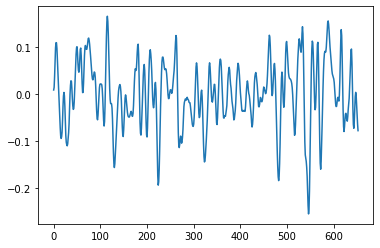

In [96]:
sub = '002'
ses = 'anatomical'
task = 'rs'
run = 1
func_fn = f'../derivatives/high_passed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz'
brain_mask = func_fn.replace('_desc-preproc_bold.nii.gz', '_desc-brain_mask.nii.gz').replace('high_passed_func', 'fmriprep/fmriprep')

# load confounds, name columns
confounds = pd.read_csv(f'../derivatives/retroicor_28_regressors/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-retroicor_regressors.tsv', sep='\t', header=None)
confounds = confounds.iloc[:,:28]
confounds

if confounds.shape[-1] > 20:
    hrv_names = ['HRV_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
    rvt_names = ['RVT_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
else:
    hrv_names = ['HRV']
    rvt_names = ['RVT']

confounds.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + hrv_names + rvt_names

plt.plot(confounds['HRV_delay_0s'].values)

In [8]:
from nilearn.glm.first_level.design_matrix import _cosine_drift
from nilearn.plotting import plot_design_matrix

def make_cosine_matrix(func, high_pass=0.01, slice_time_ref=0.5):
    t_r = func.header['pixdim'][4]
    n_scans = func.header['dim'][4]
    start_time = slice_time_ref * t_r
    end_time = (n_scans - 1 + slice_time_ref) * t_r
    frame_times = np.linspace(start_time, end_time, n_scans)
    
    cosines = pd.DataFrame(_cosine_drift(0.01, frame_times))
    cosines.columns = ['cosine_'+str(x) if (x < cosines.shape[1]-1) else 'intercept' for x in cosines.columns]
    return cosines

In [9]:
import pickle as pkl

def fit_physiology_glms(sub, ses, task, run, fwhm=4.5, models=['retroicor', 'cardiac', 'respiratory', 'interaction', 'hrv', 'rvt'], 
                        save_models=False, save_dir='../derivatives/glm_nilearn_retroicor/subject_level_models'):
    func_fn = f'../derivatives/high_passed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz'
    brain_mask = func_fn.replace('_desc-preproc_bold.nii.gz', '_desc-brain_mask.nii.gz').replace('high_passed_func', 'fmriprep/fmriprep')

    fwhm_str = str(fwhm).replace('.', 'p')
    
    # load confounds, name columns
    confounds = pd.read_csv(f'../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-retroicor_regressors.tsv', sep='\t', header=None)
    if confounds.shape[-1] > 25:      # at some point I added delays for the HRV and RVT regressors, but got rid of that again
        confounds = confounds.iloc[:,:28]
    else:
        confounds = confounds.iloc[:,:20]

    if confounds.shape[-1] > 20:
        hrv_names = ['HRV_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
        rvt_names = ['RVT_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
    else:
        hrv_names = ['HRV_delay_0s']
        rvt_names = ['RVT_delay_0s']
    
    confounds.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + hrv_names + rvt_names
    
#     # We're gonna fit 9 GLMs with increasing physiological |model complexity
    if isinstance(models, str):
        models = [models]
    
    for i, model in enumerate(models):
        
        if model == 'retroicor':
            dm = confounds[[x for x in confounds.columns if 'cardiac' in x or 'respiratory' in x]]
            vmax = .80
        elif model == 'cardiac':
            dm = confounds[[x for x in confounds.columns if 'cardiac_' in x and not 'respiratory' in x]]
            vmax = .80
        elif model == 'respiratory':
            dm = confounds[[x for x in confounds.columns if 'respiratory_' in x and not 'cardiac' in x]]
            vmax = .80
        elif model == 'interaction':
            dm = confounds[[x for x in confounds.columns if 'respiratoryxcardiac_' in x]]
            vmax = .5
        elif model == 'hrv':
            dm = confounds[['HRV_delay_0s']]
            vmax = 0.15
        elif model == 'hrv+delays':
            dm = confounds[[x for x in confounds.columns if 'HRV_' in x]]
        elif model == 'rvt':
            vmax = 0.15
            dm = confounds[['RVT_delay_0s']]
        elif model == 'rvt+delays':
            vmax = 0.1
            dm = confounds[[x for x in confounds.columns if 'RVT_' in x]]
        elif model == 'retroicor+hrv':
            vmax = 0.9
            dm = confounds[[x for x in confounds.columns if 'cardiac' in x or 'respiratory' in x or x == 'HRV_delay_0s']]
        elif model == 'retroicor+rvt':
            vmax = 0.9
            dm = confounds[[x for x in confounds.columns if 'cardiac' in x or 'respiratory' in x or x == 'RVT_delay_0s']]
        elif model == 'retroicor+hrv+rvt':
            vmax = 0.9
            dm = confounds[[x for x in confounds.columns if 'cardiac' in x or 'respiratory' in x or x == 'HRV_delay_0s' or x == 'RVT_delay_0s']]
        elif model == 'retroicor+hrv+rvt+delays':
            vmax = 0.9
            dm = confounds
            
        print(dm.shape)
        
        # z-score, make sure all regressors are mean 0 (except intercept)
        dm = dm.apply(lambda x: (x-x.mean())/x.std())

        # add intercept
        dm['intercept'] = 1

        # check for existence of final output file name
        save_fn2 = os.path.join(save_dir, f'sub-{sub}', f'sub-{sub}_ses-{ses}_task-{task}_run-{run}_model-{model}_fwhm-{fwhm_str}_space-T1w_tsnr_pred_ols.nii.gz')
        if os.path.exists(save_fn2):
            continue

        # fit
        flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, smoothing_fwhm=fwhm, noise_model='ols',  # use OLS for tSNR estimations
                              mask_img=brain_mask, n_jobs=10, minimize_memory=False,
                              signal_scaling=False)                                   # don't scale, we need tSNR estimates
        flm_fitted = flm.fit(func_fn, design_matrices=dm)

        # Get the following statistics: R-squared, predicted time series, residuals
        # tSNR: Get residuals for std, get predicted values for mean
        r2_nii = flm_fitted.r_square[0]
        
        residuals_ = flm_fitted.residuals[0]
        predicted_ = flm_fitted.predicted[0]
        
        predicted_mean = nilearn.image.math_img('nii.mean(-1)', nii=predicted_)
        res_std = nilearn.image.math_img('nii.std(-1)', nii=residuals_)
        tsnr_pred = nilearn.image.math_img('nii1/nii2', nii1=predicted_mean, nii2=res_std)
        
        for (spm_name, spm) in zip(['rsquared', 'pred_mean', 'std', 'tsnr_pred'], 
                                    [r2_nii, predicted_mean, res_std, tsnr_pred]):
            save_fn2 = os.path.join(save_dir, f'sub-{sub}', f'sub-{sub}_ses-{ses}_task-{task}_run-{run}_model-{model}_fwhm-{fwhm_str}_space-T1w_{spm_name}_ols.nii.gz')
            dirname = os.path.dirname(save_fn2)
            if not os.path.exists(dirname):
                os.makedirs(dirname)
            spm.to_filename(save_fn2)
            
            # warp
            spm_in_mni_fn = apply_warp(spm, sub=sub)
            save_fn3 = save_fn2.replace('T1w', 'MNI152NLin2009cAsym')
            os.rename(spm_in_mni_fn, save_fn3)

In [10]:
all_subs = [x.split('/')[-2] for x in sorted(glob.glob('../derivatives/retroicor/*/ses-anatomical'))]
all_subs = [x.split('-')[-1] for x in all_subs]
# all_subs

In [ ]:
import itertools
all_combs = list(itertools.product(all_subs, ['anatomical'], ['rs'], [1, 2], [0, 1.5, 6], ['retroicor', 'cardiac', 'respiratory', 'interaction', 'hrv', 'rvt', 'retroicor+hrv+rvt']))
# all_combs

def fit_physiology_glms_catch(sub, ses, task, run, fwhm, model):
    try:
        fit_physiology_glms(sub, ses, task, run, fwhm, model)
    except:
        return '{} {} {} {} {} {} FAILED'.format(sub,ses,task,run,fwhm, model)

Parallel(n_jobs=15, verbose=1)(delayed(fit_physiology_glms_catch)(sub, ses, task, run, fwhm, model) for sub, ses, task, run, fwhm, model in all_combs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  3.8min


### Fit retroicor+HRV+RVT+cosines on non-high-passed data

In [4]:
from nilearn.glm.first_level.design_matrix import _cosine_drift
from nilearn.plotting import plot_design_matrix

def make_cosine_matrix(func, high_pass=0.01, slice_time_ref=0.5):
    t_r = func.header['pixdim'][4]
    n_scans = func.header['dim'][4]
    start_time = slice_time_ref * t_r
    end_time = (n_scans - 1 + slice_time_ref) * t_r
    frame_times = np.linspace(start_time, end_time, n_scans)
    
    cosines = pd.DataFrame(_cosine_drift(0.01, frame_times))
    cosines.columns = ['cosine_'+str(x) if (x < cosines.shape[1]-1) else 'intercept' for x in cosines.columns]
    return cosines

In [12]:
import pickle as pkl

def fit_physiology_glms_cosines(sub, ses, task, run, fwhm=4.5):
    func_fn = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz'
    brain_mask = func_fn.replace('_desc-preproc_bold.nii.gz', '_desc-brain_mask.nii.gz')#.replace('high_passed_func', 'fmriprep/fmriprep')

    fwhm_str = str(fwhm).replace('.', 'p')
    
    # load confounds, name columns
    confounds_fn = f'../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-retroicor_regressors.tsv'
    # check fn
    if not os.path.exists(confounds_fn):
        return 0
    
    confounds = pd.read_csv(confounds_fn, sep='\t', header=None)
    if confounds.shape[-1] > 25:      # at some point I added delays for the HRV and RVT regressors, but got rid of that again
        confounds = confounds.iloc[:,:28]
    else:
        confounds = confounds.iloc[:,:20]

    if confounds.shape[-1] > 20:
        hrv_names = ['HRV_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
        rvt_names = ['RVT_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
    else:
        hrv_names = ['HRV_delay_0s']
        rvt_names = ['RVT_delay_0s']
    
    confounds.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + hrv_names + rvt_names
    confounds = confounds[[x for x in confounds.columns if 'cardiac' in x or 'respiratory' in x or x == 'HRV_delay_0s' or x == 'RVT_delay_0s']]
    
    # add cosines
    confounds = pd.concat([confounds, make_cosine_matrix(nib.load(func_fn))], axis=1)
    
    # check for existence of final output file name
    model = 'retroicor+hrv+rvt+cosines'
    save_fn2 = f'../derivatives/glm_nilearn_retroicor/subject_level_models3/sub-{sub}_ses-{ses}_task-{task}_run-{run}_model-{model}_fwhm-{fwhm_str}_space-T1w_tsnr_pred_ols.nii.gz'
    if os.path.exists(save_fn2):
        return 0

    # fit
    flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, smoothing_fwhm=fwhm, noise_model='ols',  # use OLS for tSNR estimations
                          mask_img=brain_mask, n_jobs=1, minimize_memory=False,
                          signal_scaling=False)                                   # don't scale, we need tSNR estimates
    flm_fitted = flm.fit(func_fn, design_matrices=confounds)

    # Get the following statistics: R-squared, predicted time series, residuals
    # tSNR: Get residuals for std, get predicted values for mean
    r2_nii = flm_fitted.r_square[0]

    residuals_ = flm_fitted.residuals[0]
    predicted_ = flm_fitted.predicted[0]

    predicted_mean = nilearn.image.math_img('nii.mean(-1)', nii=predicted_)
    res_std = nilearn.image.math_img('nii.std(-1)', nii=residuals_)
    tsnr_pred = nilearn.image.math_img('nii1/nii2', nii1=predicted_mean, nii2=res_std)

    for (spm_name, spm) in zip(['rsquared', 'pred_mean', 'std', 'tsnr_pred'], 
                                [r2_nii, predicted_mean, res_std, tsnr_pred]):
        save_fn2 = f'../derivatives/glm_nilearn_retroicor/subject_level_models3/sub-{sub}_ses-{ses}_task-{task}_run-{run}_model-{model}_fwhm-{fwhm_str}_space-T1w_{spm_name}_ols.nii.gz'
        spm.to_filename(save_fn2)

        # warp
        spm_in_mni_fn = apply_warp(spm, sub=sub)
        save_fn3 = save_fn2.replace('T1w', 'MNI152NLin2009cAsym')
        os.rename(spm_in_mni_fn, save_fn3)

In [13]:
all_subs = [x.split('/')[-2] for x in sorted(glob.glob('../derivatives/retroicor/*/ses-anatomical'))]
all_subs = [x.split('-')[-1] for x in all_subs]
# all_subs

In [14]:
import itertools
all_combs = list(itertools.product(all_subs, ['anatomical'], ['rs'], [1, 2], [0]))
# all_combs

def fit_physiology_glms_cosines_catch(sub, ses, task, run, fwhm):
    try:
        fit_physiology_glms_cosines(sub, ses, task, run, fwhm)
    except:
        return '{} {} {} {} {} {} FAILED'.format(sub,ses,task,run,fwhm)

Parallel(n_jobs=15, verbose=1)(delayed(fit_physiology_glms_cosines_catch)(sub, ses, task, run, fwhm) for sub, ses, task, run, fwhm in all_combs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    1.1s
[Parallel(n_jobs=15)]: Done  72 out of  72 | elapsed: 10.0min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## old retroicor GLMs

In [157]:
## Fit glm and save to disk
def make_first_level_model_fn(sub, ses, task, smoothing_fwhm=0, model_n='0', space='T1w', save_dir_name='../derivatives/glm_nilearn_retroicor/subject_level_model'):
    smoothing_fwhm = str(smoothing_fwhm).replace('.', 'p')
    return os.path.join(save_dir_name, f'sub-{sub}/ses-{ses}/func/fwhm-{smoothing_fwhm}/sub-{sub}_ses-{ses}_task-{task}_space-{space}_desc-first-level-model.pkl')


def fit_retroicor_glm(sub, ses, task, return_glm=False):
    
    save_fn = make_first_level_model_fn(sub, ses, task, smoothing_fwhm=0, model_n='0', space='T1w', save_dir_name='../derivatives/glm_nilearn_retroicor/subject_level_model') # f'../derivatives/{save_dir_name}/sub-{sub}/ses-{ses}/func/fwhm-{smoothing_fwhm_str}/model-{model_n}/sub-{sub}_ses-{ses}_task-{task}_space-{space}_desc-first-level-model.pkl'

    funcs = []
    dms = []
    func_fns = sorted(glob.glob('../derivatives/high_passed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_space-T1w_desc-preproc_bold.nii.gz'.format(sub=sub, ses=ses, task=task)))
    for run, func_fn in enumerate(func_fns):
        retroicor_fn = func_fn.replace('high_passed_func', 'retroicor').replace('_space-T1w_desc-preproc_bold.nii.gz', '_desc-retroicor_regressors.tsv')

        ## load func
        func = nib.load(func_fn)
        retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
        retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']

#         # add cosines  # nope, let's use the high-passed data so we can get a R^2 estimate for the physiological noise only
#         design_matrix = pd.concat([retroicor, make_cosine_matrix(func)], 1)
        retroicor['intercept'] = 1    
        design_matrix = retroicor
#         plot_design_matrix(design_matrix)
        funcs.append(func)
        dms.append(design_matrix)
    
    brain_mask = func_fns[0].replace('_desc-preproc_bold.nii.gz', '_desc-brain_mask.nii.gz').replace('high_passed_func', 'fmriprep/fmriprep')
    print('Fitting GLM for sub {} ses {} task {} ({} runs)...'.format(sub, ses, task, len(func_fns)), end='')
    
    # NB; minimize_memory=False saves the model per voxel so we can get R2 estimates to plot
    flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, smoothing_fwhm=1.5, mask_img=brain_mask, n_jobs=10)
    flm_fitted = flm.fit(funcs, design_matrices=dms)
        
    # save
    os.makedirs(os.path.dirname(save_fn), exist_ok=True)
    with open(save_fn, 'wb') as f:
        pkl.dump(flm_fitted, f, protocol=4)  # protocol=4 required due to size of pkl

    return flm_fitted



In [158]:
def find_all_to_run(return_tuple=False):
    # if you want to run everything...
    all_retroicor_regressors = sorted(glob.glob('../derivatives/retroicor/sub-*/ses-*/func/*retroicor_regressors.tsv'))
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-.*_desc-retroicor_regressors.tsv')
    all_retroicor_regressors_dict = [regex.match(x).groupdict() for x in all_retroicor_regressors]
    all_retroicor_regressors_df = pd.DataFrame.from_dict(all_retroicor_regressors_dict).sort_values(['sub','ses','task']).drop_duplicates()
    
    dict_list = all_retroicor_regressors_df.to_dict(orient='records')
    if return_tuple:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list

def find_which_to_run():
    # finds all runs for which there are RETROICOR regressors, and removes those for which there's an output already
    # ie returns the tuples corresponding to subjects for which fit_retroicor_glm hasn't been run yet
    all_retroicor_regressors = find_all_to_run()
    
    to_run = []
    for dict_ in all_retroicor_regressors:
        fp = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-retroicor_glm_SPMs.pdf'.format(**dict_)
        if not os.path.exists(fp):
#             print('{} doesnt exist'.format(fp))
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]

# find_which_to_run()

In [159]:
to_run = find_all_to_run(True)
to_run = [(x[0], x[1], x[2]) for x in to_run if x[1] == 'anatomical']
to_run

[('002', 'anatomical', 'rs'),
 ('003', 'anatomical', 'rs'),
 ('004', 'anatomical', 'rs'),
 ('005', 'anatomical', 'rs'),
 ('006', 'anatomical', 'rs'),
 ('007', 'anatomical', 'rs'),
 ('008', 'anatomical', 'rs'),
 ('009', 'anatomical', 'rs'),
 ('010', 'anatomical', 'rs'),
 ('011', 'anatomical', 'rs'),
 ('012', 'anatomical', 'rs'),
 ('013', 'anatomical', 'rs'),
 ('014', 'anatomical', 'rs'),
 ('015', 'anatomical', 'rs'),
 ('016', 'anatomical', 'rs'),
 ('017', 'anatomical', 'rs'),
 ('018', 'anatomical', 'rs'),
 ('019', 'anatomical', 'rs'),
 ('020', 'anatomical', 'rs'),
 ('021', 'anatomical', 'rs'),
 ('023', 'anatomical', 'rs'),
 ('024', 'anatomical', 'rs'),
 ('025', 'anatomical', 'rs'),
 ('026', 'anatomical', 'rs'),
 ('027', 'anatomical', 'rs'),
 ('029', 'anatomical', 'rs')]

In [134]:
fit_retroicor_glm('002', 'anatomical', 'rs')

Fitting GLM for sub 002 ses anatomical task rs (2 runs)...

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
                high_pass=0.01, hrf_model='glover',
                mask_img='../derivatives/fmriprep/fmriprep/sub-002/ses-anatomical/func/sub-002_ses-anatomical_task-rs_run-1_space-T1w_desc-brain_mask.nii.gz',
                memory=Memory(location=None), memory_level=1, min_onset=-24,
                minimize_memory=True, n_jobs=10, noise_model='ar1',
                signal_scaling=True, slice_time_ref=0.5, smoothing_fwhm=1.5,
                standardize=False, subject_label=None, t_r=1.38,
                target_affine=None, target_shape=None, verbose=0)

In [160]:
#to_run = find_all_to_run(True)

# to_run = [('002', 'anatomical', 'rs'),
#  ('003', 'rlsat', 'rlsat'),
#  ('005', 'sstmsit', 'msit'),
#  ('005', 'sstmsit', 'sst'),
# # ('007', 'rlsat', 'rlsat'),
#  ('009', 'anatomical', 'rs'),
#  ('009', 'sstmsit', 'msit'),
#  ('009', 'sstmsit', 'sst'),
#  ('010', 'anatomical', 'rs'),
#  ('011', 'anatomical', 'rs'),
#  ('011', 'rlsat', 'rlsat')]

# print(to_run)

# beware memory load
#Parallel(n_jobs=8, verbose=1)(delayed(fit_retroicor_glm)(sub, ses, task) for sub, ses, task in to_run)

def fit_retroicor_glm_catch(sub,ses,task):
    try:
        fit_retroicor_glm(sub,ses,task)
    except:
        print('{} {} {} FAILED'.format(sub,ses,task))
        return 1

## with catch
Parallel(n_jobs=5, verbose=1)(delayed(fit_retroicor_glm_catch)(sub, ses, task) for sub, ses, task in to_run)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done  26 out of  26 | elapsed: 17.1min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 1,
 None,
 None,
 1,
 None,
 1,
 None]

### Compute first-level contrasts, warp to MNI space

In [165]:
def compute_contrasts(comb, contrasts, space='T1w', save_dir_name='../derivatives/glm_nilearn_retroicor/subject_level_model'):
    sub,ses,task = comb
    
    flm_fn = f'../derivatives/glm_nilearn_retroicor/subject_level_model/sub-{sub}/ses-{ses}/func/fwhm-0/sub-{sub}_ses-{ses}_task-{task}_space-T1w_desc-first-level-model.pkl'
    with open(flm_fn, 'rb') as f:
        first_level_model = pkl.load(f)
    
    for contrast_name, contrast in contrasts.items():
        
        # save all stat maps
        stat_maps = first_level_model.compute_contrast(contrast, output_type='all')
        for stat_map_name, stat_map in stat_maps.items():
#             if not stat_map_name in ['z_score', 'effect_size', 'effect_variance']:
#                 continue  # drop p-value and 'stat'
            save_fn = flm_fn.replace('desc-first-level-model.pkl', f'desc-contrast-{contrast_name}_{stat_map_name}.nii.gz')
            stat_map.to_filename(save_fn)
            
            # warp
            stat_map_warped = apply_warp(save_fn, sub)            
            # move
            os.rename(stat_map_warped, save_fn.replace('space-T1w', 'space-MNI152NLin2009cAsym'))
    
    return 0


# Which contrasts are we interested in?
dm = flms[0].design_matrices_[0]
simple_contrasts = np.eye(dm.shape[1])
contrasts = {'cardiac': simple_contrasts[:6,:],
             'respiratory': simple_contrasts[6:(6+8),:],
             'interaction': simple_contrasts[(6+8):(6+8+4),:],
             'RETROICOR': simple_contrasts[:(6+8+4),:],
             'HRV': simple_contrasts[18,:],
             'RVT': simple_contrasts[19,:],
             }

# Multiprocess
def compute_contrasts_catch(comb, contrasts):
    try:
        compute_contrasts(comb, contrasts)
    except:
        print('{} {} {} FAILED'.format(sub,ses,task))
        return 1


Parallel(n_jobs=20, verbose=1)(delayed(compute_contrasts_catch)( (sub, ses, task), contrasts=contrasts ) for sub, ses, task in to_run)

#compute_contrasts(to_run[0], contrasts)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  26 out of  26 | elapsed:  9.5min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 1,
 None,
 None,
 1,
 None,
 1,
 None]

## Second level model

In [147]:
# slm = nilearn.glm.second_level.SecondLevelModel()
# slm = slm.fit()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:576: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


In [169]:
#fwhm = 1.5
#fwhm_str = str(fwhm).replace('.', 'p')
#model_n = 0

#contrast_name = 'SPD-ACC'
imgs = sorted(glob.glob(f'../derivatives/glm_nilearn_retroicor/subject_level_model/sub-*/ses-anatomical/func/fwhm-*/*MNI*desc-contrast-*_effect_size*'))
regex = re.compile('.*/sub-(?P<sub>\d+)/.*/fwhm-(?P<fwhm>\S+)/sub-.*_desc-contrast-(?P<contrast_name>\S+)_effect_size.nii.gz')

df = pd.DataFrame({'effects_map_path':imgs})
df['subject_label'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['sub'])
df['fwhm'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['fwhm'])
#df['model_n'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['model_n'])
df['map_name'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['contrast_name'])
df.head()

,effects_map_path,subject_label,fwhm,map_name
0,../derivatives/glm_nilearn_retroicor/subject_l...,002,0,HRV
1,../derivatives/glm_nilearn_retroicor/subject_l...,002,0,RETROICOR
2,../derivatives/glm_nilearn_retroicor/subject_l...,002,0,RVT
3,../derivatives/glm_nilearn_retroicor/subject_l...,002,0,cardiac
4,../derivatives/glm_nilearn_retroicor/subject_l...,002,0,interaction


In [200]:
def fit_second_level_model(first_level_contrast, df, fwhm=None):
    df_in = df.loc[(df.map_name==first_level_contrast) & (df.fwhm==str(0).replace('.', 'p'))].copy()
    dm_in = df_in.copy()
    dm_in['intercept'] = 1
    dm_in = dm_in[['intercept']].reset_index(drop=True)

    slm = nilearn.glm.second_level.SecondLevelModel(n_jobs=20, smoothing_fwhm=fwhm)
    slm = slm.fit(df_in.effects_map_path.values.tolist(), design_matrix=dm_in)
    return slm

## No smoothing

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


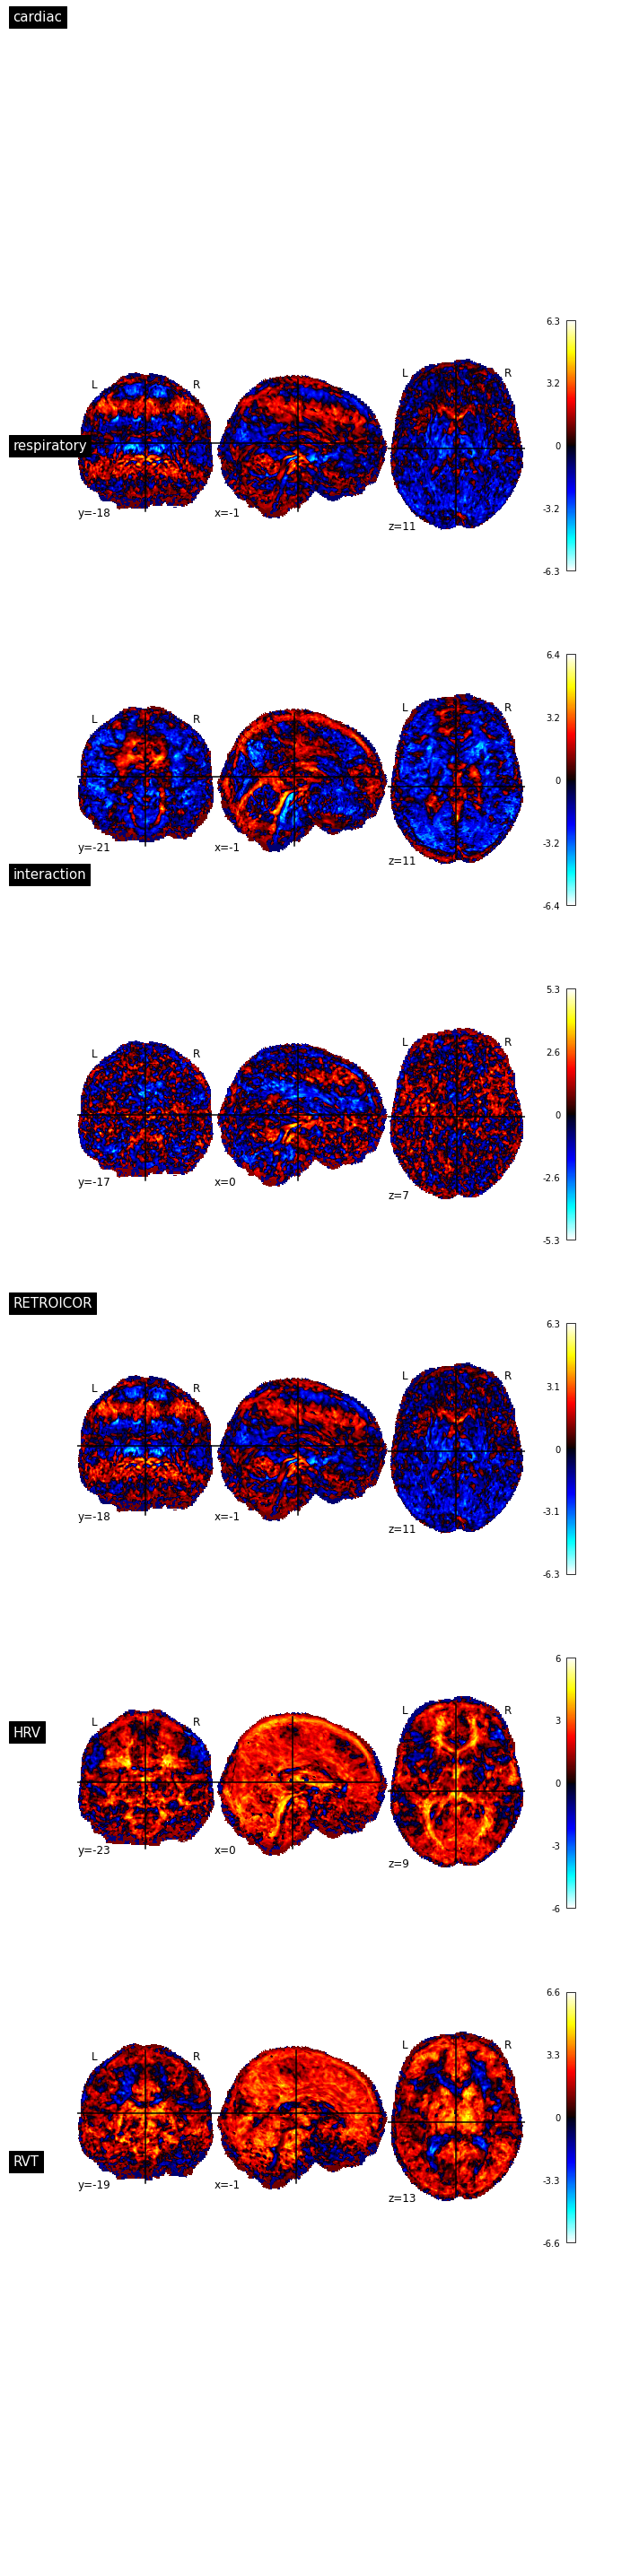

In [208]:
f, ax = plt.subplots(6,1, figsize=(10,40))
for i, contrast_name in enumerate(['cardiac', 'respiratory', 'interaction', 'RETROICOR', 'HRV', 'RVT']):
    slm = fit_second_level_model(contrast_name, df)
    z_map = slm.compute_contrast('intercept', output_type='z_score')
    plotting.plot_stat_map(z_map, axes=ax[i], title=contrast_name)
f.tight_layout()

## With 4.5 mm smoothing

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


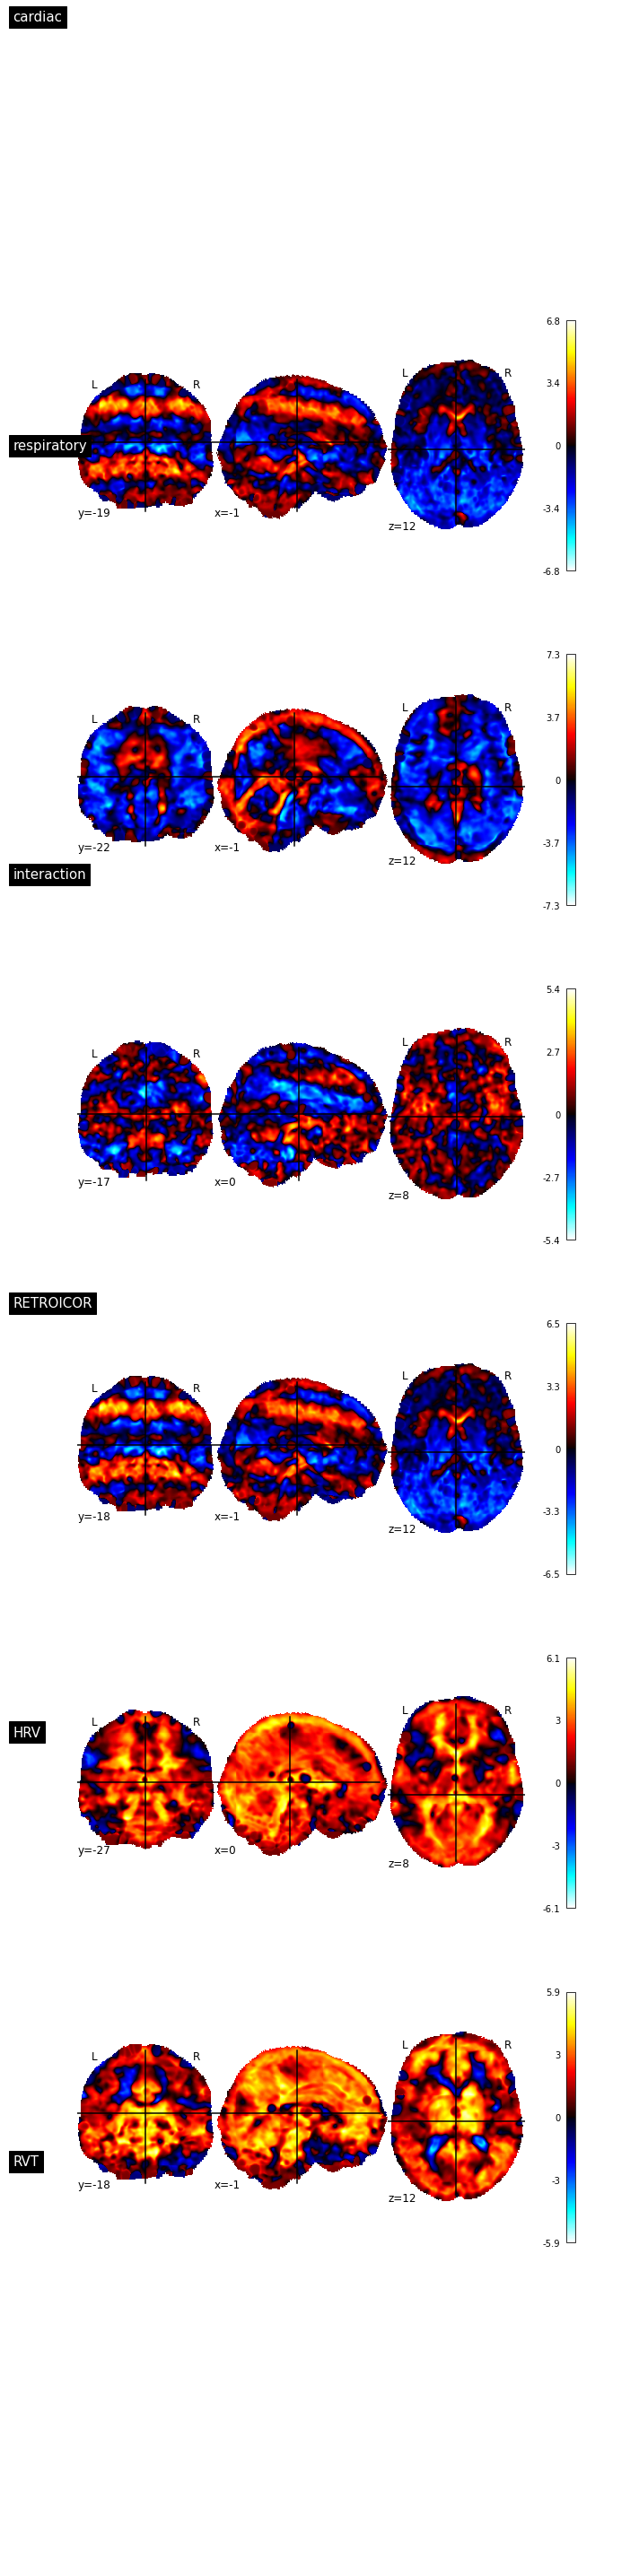

In [209]:
f, ax = plt.subplots(6,1, figsize=(10,40))
for i, contrast_name in enumerate(['cardiac', 'respiratory', 'interaction', 'RETROICOR', 'HRV', 'RVT']):
    slm = fit_second_level_model(contrast_name, df, fwhm=4.5)
    z_map = slm.compute_contrast('intercept', output_type='z_score')
    plotting.plot_stat_map(z_map, axes=ax[i], title=contrast_name)
f.tight_layout()

In [205]:
del flms

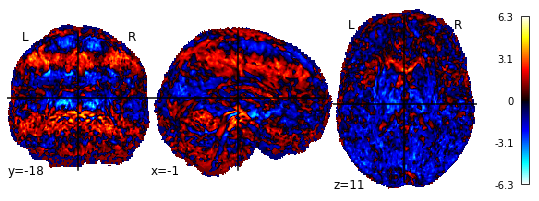

In [195]:
slm_retroicor = fit_second_level_model('RETROICOR', df)
z_map_retroicor = slm_retroicor.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_retroicor)

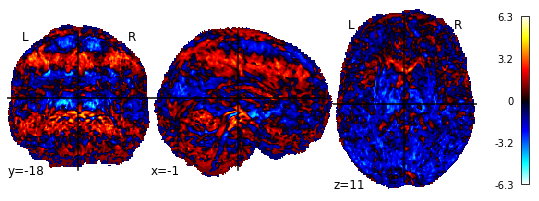

In [196]:
slm_cardiac = fit_second_level_model('cardiac', df)
z_map_cardiac = slm_cardiac.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_cardiac)

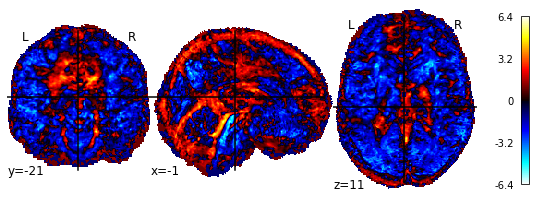

In [193]:
slm_respiratory = fit_second_level_model('respiratory', df)
z_map_respiratory = slm_respiratory.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_respiratory)

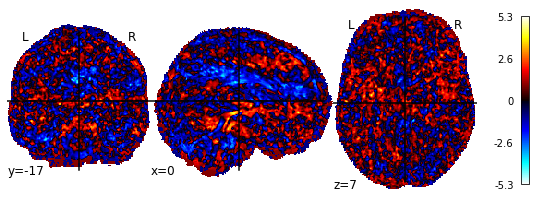

In [194]:
slm_interaction = fit_second_level_model('interaction', df)
z_map_interaction = slm_interaction.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_interaction)

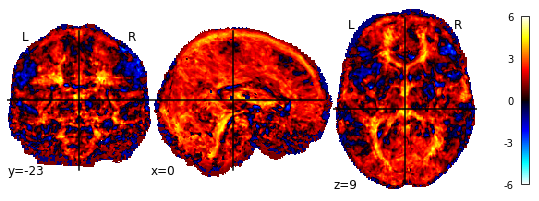

In [197]:
slm_HRV = fit_second_level_model('HRV', df)
z_map_HRV = slm_HRV.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_HRV)

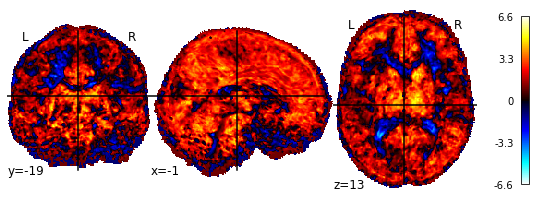

In [198]:
slm_RVT = fit_second_level_model('RVT', df)
z_map_RVT = slm_RVT.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_RVT)

In [170]:
def save_second_level_spm(spm, first_level_contrast_name, second_level_contrast_name, fwhm, save_dir_name='../derivatives/glm_nilearn_retroicor/group_level_model/ses-anatomical'):
    fwhm = str(fwhm).replace('.', 'p')
    save_fn = os.path.join(save_dir_name, f'fwhm-{fwhm}/firstlevelcontrast-{first_level_contrast_name}_secondlevelcontrast-{second_level_contrast_name}.nii.gz')
    
    if not os.path.exists(os.path.dirname(save_fn)):
        os.makedirs(os.path.dirname(save_fn))
    
    spm.to_filename(save_fn)
    nilearn.image.math_img('-nii', nii=spm).to_filename(save_fn.replace('.nii.gz', '-neg.nii.gz'))
    
def fit_second_level_models(first_level_contrast, second_level_contrast, fwhm, df):
    print(f'{fwhm} {model_n} {first_level_contrast}')
    dm = df.loc[(df.map_name==first_level_contrast) & (df.fwhm==str(fwhm).replace('.', 'p'))].copy()
    #dm = pd.merge(df_in, parameters[['subject_label', 'B0.SPD-ACC_z']]) #, 'V0.SPD-ACC_z']])
    dm['intercept'] = 1

#     if first_level_contrast == 'SPD-ACC':
#         dm_in = dm[['intercept', 'B0.SPD-ACC_z']] #, 'V0.SPD-ACC_z']]
#     else:
    dm_in = dm[['intercept']]
    
    slm = SecondLevelModel()
    slm_fitted = slm.fit(second_level_input=df_in.effects_map_path.values.tolist(), design_matrix=dm_in)

    # Intercept, threshold covariance, urgency covariance
    cmap = slm_fitted.compute_contrast('intercept', output_type='z_score')
    save_second_level_spm(cmap, first_level_contrast_name=first_level_contrast, second_level_contrast_name=second_level_contrast, fwhm=fwhm)

In [172]:
df.map_name.unique()

array(['HRV', 'RETROICOR', 'RVT', 'cardiac', 'interaction', 'respiratory'],
      dtype=object)

In [175]:
import itertools
all_combs = list(itertools.product(df.map_name.unique().tolist(), ['intercept'], [0]))
all_combs

_ = joblib.Parallel(n_jobs=10, verbose=1)(joblib.delayed(fit_second_level_models)(first_level_contrast, second_level_contrast, fwhm, df=df) for first_level_contrast,second_level_contrast,fwhm in all_combs)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


TypeError: fit_second_level_models() missing 1 required positional argument: 'parameters'

In [153]:
z1 = slm.compute_contrast(first_level_contrast=contrasts['cardiac'])

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:576: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/glm/contrasts.py:352: UserWarning: Running approximate fixed effects on F statistics.
  warn('Running approximate fixed effects on F statistics.')


ValueError: Field of view of image #1 is different from reference FOV.
Reference affine:
array([[  1.5       ,   0.        ,   0.        , -66.08146667],
       [  0.        ,   1.5       ,   0.        , -86.61924744],
       [  0.        ,   0.        ,   1.5       , -71.01078033],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
Image affine:
array([[  1.5       ,   0.        ,   0.        , -67.697258  ],
       [  0.        ,   1.5       ,   0.        , -85.34696198],
       [  0.        ,   0.        ,   1.5       , -66.86791992],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
Reference shape:
(90, 118, 95)
Image shape:
(93, 121, 95, 1)


In [ ]:
plotting.plot_stat_map(z1)

In [15]:
def fit_retroicor_glm(sub, ses, task, return_glm=False):
    funcs = []
    dms = []
    func_fns = sorted(glob.glob('../derivatives/high_passed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_space-T1w_desc-preproc_bold.nii.gz'.format(sub=sub, ses=ses, task=task)))
    for run, func_fn in enumerate(func_fns):
        retroicor_fn = func_fn.replace('high_passed_func', 'retroicor').replace('_space-T1w_desc-preproc_bold.nii.gz', '_desc-retroicor_regressors.tsv')

        ## load func
        func = nib.load(func_fn)
        retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
        retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']

#         # add cosines  # nope, let's use the high-passed data so we can get a R^2 estimate for the physiological noise only
#         design_matrix = pd.concat([retroicor, make_cosine_matrix(func)], 1)
        retroicor['intercept'] = 1    
        design_matrix = retroicor
#         plot_design_matrix(design_matrix)
        funcs.append(func)
        dms.append(design_matrix)
    
    brain_mask = func_fns[0].replace('_desc-preproc_bold.nii.gz', '_desc-brain_mask.nii.gz').replace('high_passed_func', 'fmriprep/fmriprep')
    print('Fitting GLM for sub {} ses {} task {} ({} runs)...'.format(sub, ses, task, len(func_fns)), end='')
    
    # NB; minimize_memory=False saves the model per voxel so we can get R2 estimates to plot
    flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, smoothing_fwhm=4.5, mask_img=brain_mask, n_jobs=10, minimize_memory=False)    # lekker smoothen
    flm_fitted = flm.fit(funcs, design_matrices=dms)

    # define & plot contrasts
    simple_contrasts = np.eye(dms[0].shape[1])
    contrasts = {'cardiac': simple_contrasts[:6,:],
                 'respiratory': simple_contrasts[6:(6+8),:],
                 'interaction': simple_contrasts[(6+8):(6+8+4),:],
                 'HRV': simple_contrasts[18,:],
                 'RVT': simple_contrasts[19,:],
                 }

    print('plotting...')
    vmaxes = {'cardiac': 37, 'respiratory': 30, 'interaction': 15, 'HRV': 10, 'RVT': 8}
    templ = '../sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

    f, ax = plt.subplots(6,3, figsize=(12,15), gridspec_kw={'hspace': 0, 'wspace': 0})
    for i, (contrast_name, c_) in enumerate(contrasts.items()):
        z_map_ftest = flm_fitted.compute_contrast(
                               c_,
                               stat_type='F',
                               output_type='z_score')
        vmax = vmaxes[contrast_name]
        
        # warp to MNI
        z_map_ftest = apply_warp(z_map_ftest, sub=sub)
        
        plotting.plot_stat_map(z_map_ftest, bg_img=nib.load(templ), vmax=vmax, title=contrast_name, display_mode='x', cut_coords=[3], axes=ax[i,0], colorbar=False)
        plotting.plot_stat_map(z_map_ftest, bg_img=nib.load(templ), vmax=vmax, display_mode='y', cut_coords=[-3], axes=ax[i,1], colorbar=False)
        plotting.plot_stat_map(z_map_ftest, bg_img=nib.load(templ), vmax=vmax, display_mode='z', cut_coords=[15], axes=ax[i,2])
        os.remove(z_map_ftest) # cleanup
    
    # plot
    r2_nii = flm_fitted.r_square[0]
    r2_nii = apply_warp(r2_nii, sub=sub) # warp to MNI
    plotting.plot_stat_map(r2_nii, bg_img=nib.load(templ), vmax=0.6, title='R^2', display_mode='x', cut_coords=[3], axes=ax[-1,0], colorbar=False)
    plotting.plot_stat_map(r2_nii, bg_img=nib.load(templ), vmax=0.6, display_mode='y', cut_coords=[-3], axes=ax[-1,1], colorbar=False)
    plotting.plot_stat_map(r2_nii, bg_img=nib.load(templ), vmax=0.6, display_mode='z', cut_coords=[15], axes=ax[-1,2])
    os.remove(r2_nii) # cleanup
    
    plot_fn = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-retroicor_glm_SPMs.pdf'.format(sub=sub, ses=ses, task=task)
    os.makedirs(os.path.dirname(plot_fn), exist_ok=True)
#     plot_fn = retroicor_fn.replace('_desc-retroicor_regressors.tsv', '_retroicor-glm.pdf').replace('_run-2', '').replace('_run-1', '').replace('_run-3', '')
    f.savefig(plot_fn, bbox_inches='tight')
    
    if return_glm:
        return flm_fitted
    else:
        del flm_fitted
        return 0

In [111]:
def find_all_to_run(return_tuple=False):
    # if you want to run everything...
    all_retroicor_regressors = sorted(glob.glob('../derivatives/retroicor/sub-*/ses-*/func/*retroicor_regressors.tsv'))
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-.*_desc-retroicor_regressors.tsv')
    all_retroicor_regressors_dict = [regex.match(x).groupdict() for x in all_retroicor_regressors]
    all_retroicor_regressors_df = pd.DataFrame.from_dict(all_retroicor_regressors_dict).sort_values(['sub','ses','task']).drop_duplicates()
    
    dict_list = all_retroicor_regressors_df.to_dict(orient='records')
    if return_tuple:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list

def find_which_to_run():
    # finds all runs for which there are RETROICOR regressors, and removes those for which there's an output already
    # ie returns the tuples corresponding to subjects for which fit_retroicor_glm hasn't been run yet
    all_retroicor_regressors = find_all_to_run()
    
    to_run = []
    for dict_ in all_retroicor_regressors:
        fp = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-retroicor_glm_SPMs.pdf'.format(**dict_)
        if not os.path.exists(fp):
#             print('{} doesnt exist'.format(fp))
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]

find_which_to_run()

[('007', 'sstmsit', 'msit'),
 ('010', 'rlsat', 'rlsat'),
 ('012', 'rbrevl', 'rb'),
 ('012', 'rbrevl', 'revl'),
 ('014', 'sstmsit', 'msit'),
 ('014', 'sstmsit', 'sst'),
 ('015', 'rlsat', 'rlsat'),
 ('018', 'rbrevl', 'rb'),
 ('018', 'rlsat', 'rlsat'),
 ('018', 'sstmsit', 'sst'),
 ('019', 'rbrevl', 'revl'),
 ('021', 'anatomical', 'rs'),
 ('021', 'sstmsit', 'msit'),
 ('021', 'sstmsit', 'sst'),
 ('023', 'anatomical', 'rs'),
 ('023', 'rbrevl', 'rb'),
 ('023', 'rbrevl', 'revl'),
 ('023', 'rlsat', 'rlsat'),
 ('023', 'sstmsit', 'msit'),
 ('023', 'sstmsit', 'sst'),
 ('024', 'anatomical', 'rs'),
 ('024', 'rlsat', 'rlsat'),
 ('024', 'sstmsit', 'msit'),
 ('024', 'sstmsit', 'sst'),
 ('025', 'anatomical', 'rs'),
 ('025', 'rbrevl', 'rb'),
 ('025', 'rbrevl', 'revl'),
 ('026', 'anatomical', 'rs'),
 ('026', 'rbrevl', 'rb'),
 ('026', 'rbrevl', 'revl'),
 ('026', 'rlsat', 'rlsat'),
 ('026', 'sstmsit', 'msit'),
 ('026', 'sstmsit', 'sst'),
 ('027', 'anatomical', 'rs'),
 ('029', 'anatomical', 'rs'),
 ('029', '

In [53]:
to_run = find_which_to_run()
#to_run = find_all_to_run(True)

# to_run = [('002', 'anatomical', 'rs'),
#  ('003', 'rlsat', 'rlsat'),
#  ('005', 'sstmsit', 'msit'),
#  ('005', 'sstmsit', 'sst'),
# # ('007', 'rlsat', 'rlsat'),
#  ('009', 'anatomical', 'rs'),
#  ('009', 'sstmsit', 'msit'),
#  ('009', 'sstmsit', 'sst'),
#  ('010', 'anatomical', 'rs'),
#  ('011', 'anatomical', 'rs'),
#  ('011', 'rlsat', 'rlsat')]

# print(to_run)

# beware memory load
#Parallel(n_jobs=8, verbose=1)(delayed(fit_retroicor_glm)(sub, ses, task) for sub, ses, task in to_run)

def fit_retroicor_glm_catch(sub,ses,task):
    try:
        fit_retroicor_glm(sub,ses,task)
    except:
        print('{} {} {} FAILED'.format(sub,ses,task))
        return 1
    
## with catch
Parallel(n_jobs=5, verbose=1)(delayed(fit_retroicor_glm_catch)(sub, ses, task) for sub, ses, task in to_run)

# for sub,ses,task in to_run:
#     print(sub,ses,task)
#     try:
#         fit_retroicor_glm(sub,ses,task)
#     except:
#         print('FAILED: ')
#         print(sys.exc_info()[0])

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:  9.7min finished


[1, 1, None, None, None, None, 1, 1, 1]

In [54]:
find_which_to_run()

[('007', 'sstmsit', 'msit'),
 ('010', 'rlsat', 'rlsat'),
 ('018', 'rlsat', 'rlsat'),
 ('018', 'sstmsit', 'sst'),
 ('019', 'rbrevl', 'revl')]

# 3. Left > Right motor response (only for non-RS, obviously)

In [ ]:
def plot_responsehand_glms(glms, sub, x=34, y=-20, z=58):
    zs = [x.compute_contrast('response_left - response_right') for x in glms]
    
    templ = '../sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

    contrast_name = 'left>right'
    n_runs = len(zs)
    f, ax = plt.subplots(n_runs,3, figsize=(12, n_runs*2), gridspec_kw={'hspace': 0, 'wspace': 0})
    
    if n_runs > 1:
        for run in range(n_runs-1):
            # warp z-map to mni
            z_map = zs[run]
            z_map = apply_warp(z_map, sub=sub)
            
            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), title='Run {}'.format(run+1), display_mode='x', cut_coords=[x], axes=ax[run,0], colorbar=False)
            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='y', cut_coords=[y], axes=ax[run,1], colorbar=False)
            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='z', cut_coords=[z], axes=ax[run,2])
            os.remove(z_map) # clean-up
    
    run = n_runs-1
    z_map = zs[run]
    z_map = apply_warp(z_map, sub=sub)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), title='Fixed effects across runs', display_mode='x', cut_coords=[x], axes=ax[run,0], colorbar=False)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='y', cut_coords=[y], axes=ax[run,1], colorbar=False)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='z', cut_coords=[z], axes=ax[run,2])
    os.remove(z_map)
    return f, ax

def fit_responsehand_glm(sub, ses, task, include_physio=True, per_run=True, return_glms=False):
    event_fns = sorted(glob.glob('../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_events.tsv'.format(sub=sub, ses=ses, task=task)))
    run_flms = []
    run_events = []
    run_funcs = []
    run_confounds = []

    for run, event_fn in enumerate(event_fns):
        run += 1
        events = pd.read_csv(event_fn, sep='\t', index_col=None)
        events = events.loc[events.trial_type.isin(['response_left', 'response_right'])] 
        events['duration'] = 0.001
        run_events.append(events)

        ## load func
        func_fn = '../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz'.format(sub=sub, ses=ses, task=task, run=run)
        brain_mask = func_fn.replace('desc-preproc_bold', 'desc-brain_mask')
        func = nib.load(func_fn)
        run_funcs.append(func)
        
        if include_physio:
            ## load confounds
            retroicor_fn = func_fn.replace('fmriprep/fmriprep', 'retroicor').replace('_space-T1w_desc-preproc_bold.nii.gz', '_desc-retroicor_regressors.tsv')
            retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
            retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
        else:
            retroicor=None
        
        run_confounds.append(retroicor)
        
        # fit run-level model
        if per_run:
            flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, mask_img=brain_mask, smoothing_fwhm=4.5, n_jobs=20)  # lekker smoothen
            flm_fitted = flm.fit(func, events=events, confounds=retroicor)
            run_flms.append(flm_fitted)
        
    flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, mask_img=brain_mask, smoothing_fwhm=4.5, n_jobs=20)  # lekker smoothen
    flm_fitted = flm.fit(run_funcs, events=run_events, confounds=run_confounds if include_physio else None)
    run_flms.append(flm_fitted)
    
    f, ax = plot_responsehand_glms(run_flms, sub)
    plot_fn = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-motor_contrast_glm_SPMs.pdf'.format(sub=sub, ses=ses, task=task)
#     plot_fn = event_fns[0].replace('event_files', 'quality_control_plots').replace('_events.tsv', '_desc-motor_contrast.pdf')
    os.makedirs(os.path.dirname(plot_fn), exist_ok=True)
    f.savefig(plot_fn)
    
    if return_glms:
        return run_flms
    else:
        del run_flms
        return 0
    
def plot_responsefinger_glms(glms, response_contrast, sub, x=34, y=-20, z=58):
    
    #for response_contrast in ['response_index - response_middle', 'response_index - response_ring', 'response_ring - response_middle']
    
    #zs = [x.compute_contrast('response_index - response_middle') for x in glms]
    zs = [x.compute_contrast(response_contrast) for x in glms]

    templ = '../sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

    contrast_name = 'index>middle'
    n_runs = len(zs)
    f, ax = plt.subplots(n_runs,3, figsize=(12, n_runs*2), gridspec_kw={'hspace': 0, 'wspace': 0})

    if n_runs > 1:
        for run in range(n_runs-1):
            z_map = zs[run]
            z_map = apply_warp(z_map, sub=sub)

            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), title='Run {}'.format(run+1), display_mode='x', cut_coords=[x], axes=ax[run,0], colorbar=False)
            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='y', cut_coords=[y], axes=ax[run,1], colorbar=False)
            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='z', cut_coords=[z], axes=ax[run,2])
            os.remove(z_map)
            
    run = n_runs-1
    z_map = zs[run]
    z_map = apply_warp(z_map, sub=sub)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), title='Fixed effects across runs', display_mode='x', cut_coords=[x], axes=ax[run,0], colorbar=False)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='y', cut_coords=[y], axes=ax[run,1], colorbar=False)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='z', cut_coords=[z], axes=ax[run,2])
    os.remove(z_map)
    return f, ax

def fit_responsefinger_glm(sub, ses, task, include_physio=True, per_run=True, return_glms=False):
    
    event_fns = sorted(glob.glob('../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_events.tsv'.format(sub=sub, ses=ses, task=task)))
    run_flms = []
    run_events = []
    run_funcs = []
    run_confounds = []

    for run, event_fn in enumerate(event_fns):
        run += 1
        events = pd.read_csv(event_fn, sep='\t', index_col=None)
        events = events.loc[events.trial_type.isin(['response_index', 'response_middle','response_ring'])] 
        events['duration'] = 0.001
        run_events.append(events)

        ## load func
        func_fn = '../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz'.format(sub=sub, ses=ses, task=task, run=run)
        brain_mask = func_fn.replace('desc-preproc_bold', 'desc-brain_mask')
        func = nib.load(func_fn)
        run_funcs.append(func)
        
        if include_physio:
            ## load confounds
            retroicor_fn = func_fn.replace('fmriprep/fmriprep', 'retroicor').replace('_space-T1w_desc-preproc_bold.nii.gz', '_desc-retroicor_regressors.tsv')
            retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
            retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
        else:
            retroicor=None
        
        run_confounds.append(retroicor)
        
        # fit run-level model
        if per_run:
            flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, mask_img=brain_mask, smoothing_fwhm=4.5, n_jobs=20)  # lekker smoothen
            flm_fitted = flm.fit(func, events=events, confounds=retroicor)
            run_flms.append(flm_fitted)
        
    flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, mask_img=brain_mask, smoothing_fwhm=4.5, n_jobs=20)  # lekker smoothen
    flm_fitted = flm.fit(run_funcs, events=run_events, confounds=run_confounds if include_physio else None)
    run_flms.append(flm_fitted)
    
    for response_contrast, save_contrast in zip(['response_index - response_middle', 'response_index - response_ring', 'response_ring - response_middle'],['IminM','IminR','RminM']):
        f, ax = plot_responsefinger_glms(run_flms, response_contrast, sub)
        plot_fn = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-motor_contrast-{save_contrast}_glm_SPMs.pdf'.format(sub=sub, ses=ses, task=task, save_contrast=save_contrast)
    #     plot_fn = event_fns[0].replace('event_files', 'quality_control_plots').replace('_events.tsv', '_desc-motor_contrast.pdf')
        os.makedirs(os.path.dirname(plot_fn), exist_ok=True)
        f.savefig(plot_fn)
    
    if return_glms:
        return run_flms
    else:
        del run_flms
        return 0

## Non-MSIT

In [ ]:
def find_all_to_run_nonmsit(return_tuple=False):
    # if you want to run everything...
    all_event_files = sorted(glob.glob('../derivatives/event_files/sub-*/ses-*/func/sub-*_ses-*_task-*_run-*_events.tsv'))
    all_event_files = [x for x in all_event_files if not 'task-msit' in x]
    
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-.*_events.tsv')
    all_event_files_dict = [regex.match(x).groupdict() for x in all_event_files]
    all_event_files_df = pd.DataFrame.from_dict(all_event_files_dict).sort_values(['sub','ses','task']).drop_duplicates()
    
    dict_list = all_event_files_df.to_dict(orient='records')
    if return_tuple:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list

def find_which_to_run_nonmsit():
    # finds all runs for which there are RETROICOR regressors, and removes those for which there's an output already
    # ie returns the tuples corresponding to subjects for which fit_retroicor_glm hasn't been run yet
    all_event_files = find_all_to_run_nonmsit()
    
    to_run = []
    for dict_ in all_event_files:
        fp = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-motor_contrast_glm_SPMs.pdf'.format(**dict_)
        if not os.path.exists(fp):
#             print('{} doesnt exist'.format(fp))
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]

In [ ]:
to_run = find_all_to_run_nonmsit(True)
to_run = find_which_to_run_nonmsit()
print(to_run)

## joblib, also here careful with n_jobs
Parallel(n_jobs=10, verbose=1)(delayed(fit_responsehand_glm)(sub, ses, task) for sub, ses, task in to_run)

## MSIT

In [97]:
def find_all_to_run_msit(return_tuple=False):
    # if you want to run everything...
    all_event_files = sorted(glob.glob('../derivatives/event_files/sub-*/ses-*/func/sub-*_ses-*_task-msit_run-*_events.tsv'))
    
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-.*_events.tsv')
    all_event_files_dict = [regex.match(x).groupdict() for x in all_event_files]
    all_event_files_df = pd.DataFrame.from_dict(all_event_files_dict).sort_values(['sub','ses','task']).drop_duplicates()
    
    dict_list = all_event_files_df.to_dict(orient='records')
    if return_tuple:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list

def find_which_to_run_msit():
    # finds all runs for which there are RETROICOR regressors, and removes those for which there's an output already
    # ie returns the tuples corresponding to subjects for which fit_retroicor_glm hasn't been run yet
    all_event_files = find_all_to_run_msit()
    
    to_run = []
    for dict_ in all_event_files:
        fp = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-motor_contrast-IminM_glm_SPMs.pdf'.format(**dict_)
        if not os.path.exists(fp):
#             print('{} doesnt exist'.format(fp))
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]

In [98]:
to_run = find_all_to_run_msit(True) #[('003', 'sstmsit', 'msit')]
print(to_run)
# to_fit = [('003', 'sstmsit', 'msit')]

## joblib, also here careful with n_jobs
Parallel(n_jobs=4, verbose=1)(delayed(fit_responsefinger_glm)(sub, ses, task) for sub, ses, task in to_run)

[('002', 'sstmsit', 'msit'), ('003', 'sstmsit', 'msit'), ('004', 'sstmsit', 'msit'), ('006', 'sstmsit', 'msit')]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.4min remaining:  8.4min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.6min finished


[0, 0, 0, 0]